In [1]:
import sys
#sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
sys.path.append('../keypoints/partes')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
from process_file import datos_subprocesados_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
class parameters:
    def __init__(self):
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = False
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints'
        self.directory_flujo='../keypoints'

In [3]:
# Cargamos los argumentos
arguments = parameters()

# List of data directories where raw data resides
datasets_entrena_vali = [0,1,3,4]
datasets_prueba = [2]

data_entrena_vali = datos_subprocesados_varios(datasets_entrena_vali, arguments, ',')
data_prueba = datos_subprocesados_varios(datasets_prueba, arguments, ',')
#data_ucyuniv = process_file_modif_varios(ucyuniv_pix_path, arguments, ',')

../data1/eth/univ/mundo/mun_pos.csv
339
../data1/eth/hotel/mundo/mun_pos.csv
913
../data1/ucy/zara/zara02/mundo/mun_pos.csv
5910
../data1/ucy/univ/mundo/mun_pos.csv
10039
(17201, 8, 64)
../data1/ucy/zara/zara01/mundo/mun_pos.csv
2356
(2356, 8, 64)


# Dividimos los datos

In [7]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.92
# La cantidad total de listas de tam 8 
ndata = len(data_entrena_vali[list(data_entrena_vali.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata-long1)


idx_train = idx[0:long1]
idx_val = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_entrena_vali["obs_traj"][idx_train],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_train],
    
     "pred_traj": data_entrena_vali["pred_traj"][idx_train],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_train],
    
     "key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_entrena_vali["obs_traj"][idx_val],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_val],
     "pred_traj": data_entrena_vali["pred_traj"][idx_val],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_val],
     "key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_prueba[list(data_prueba .keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 15824
data_test: 2356
data_val: 1377


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Guardamos la division de los datos

In [8]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_UCYZARA01_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_UCYZARA01_12.pickle","wb")
pickle.dump(data_prueba, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_UCYZARA01_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros para entrenar el modelo

In [9]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.001 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [10]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA01_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('SINKP_NON_UCYZARA01-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA01_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0102 11:26:02.908129 139831356811008 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0102 11:26:02.938031 139831356811008 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 11:26:02.956227 139831356811008 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0102 11:26:02.958884 139831356811008 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

792
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/69 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 41.03it/s]

{'ade': 1.552503, 'fde': 2.8127651}
	 last loss:-1.000000000, eval on validation:['ade: 1.552503', 'fde: 2.8127651'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 73.08it/s]

{'ade': 0.5363264, 'fde': 1.1737027}
	 last loss:0.000719435, eval on validation:['ade: 0.5363264', 'fde: 1.1737027'], (best ade:1.552503 at step 1) 
	 saving best model...
	 done.


 76%|███████▌  | 598/792 [00:28<00:07, 25.90it/s]W0102 11:26:34.703392 139831356811008 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



 76%|███████▌  | 601/792 [00:29<00:28,  6.71it/s]A

{'ade': 0.5892745, 'fde': 1.3145453}
	 last loss:0.000581733, eval on validation:['ade: 0.5892745', 'fde: 1.3145453'], (best ade:0.5363264 at step 300) 


  0%|          | 1/792 [00:00<01:46,  7.40it/s]

('Epoca 2.', 'lr:', 0.002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 78.05it/s]

{'ade': 0.5125759, 'fde': 1.1083512}
	 last loss:0.000655281, eval on validation:['ade: 0.5125759', 'fde: 1.1083512'], (best ade:0.5363264 at step 300) 
	 saving best model...


  0%|          | 0/69 [00:00<?, ?it/s]

	 done.
	saving model 1200...
	done
Evaluating



 52%|█████▏    | 412/792 [00:18<00:43,  8.73it/s]A

{'ade': 0.5436599, 'fde': 1.1887723}
	 last loss:0.000559559, eval on validation:['ade: 0.5436599', 'fde: 1.1887723'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 90%|████████▉ | 709/792 [00:31<00:11,  7.12it/s]A

{'ade': 0.51295877, 'fde': 1.1050907}
	 last loss:0.000601996, eval on validation:['ade: 0.51295877', 'fde: 1.1050907'], (best ade:0.5125759 at step 900) 


  0%|          | 2/792 [00:00<00:45, 17.44it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



 28%|██▊       | 218/792 [00:09<01:27,  6.58it/s]A

{'ade': 0.56997323, 'fde': 1.2788625}
	 last loss:0.000374383, eval on validation:['ade: 0.56997323', 'fde: 1.2788625'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



 65%|██████▌   | 517/792 [00:22<00:43,  6.30it/s]A

{'ade': 0.5325975, 'fde': 1.1745514}
	 last loss:0.000586863, eval on validation:['ade: 0.5325975', 'fde: 1.1745514'], (best ade:0.5125759 at step 900) 


  0%|          | 3/792 [00:00<00:32, 24.11it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



  3%|▎         | 27/792 [00:02<01:27,  8.78it/s][A

{'ade': 0.5903055, 'fde': 1.3135505}
	 last loss:0.000773226, eval on validation:['ade: 0.5903055', 'fde: 1.3135505'], (best ade:0.5125759 at step 900) 


 41%|████      | 321/792 [00:13<00:19, 24.62it/s]


	saving model 2700...
	done
Evaluating


 41%|████▏     | 327/792 [00:15<00:56,  8.18it/s]A

{'ade': 0.5290397, 'fde': 1.1598231}
	 last loss:0.000590845, eval on validation:['ade: 0.5290397', 'fde: 1.1598231'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



 79%|███████▉  | 627/792 [00:28<00:20,  8.21it/s]A

{'ade': 0.5752419, 'fde': 1.276684}
	 last loss:0.000439015, eval on validation:['ade: 0.5752419', 'fde: 1.276684'], (best ade:0.5125759 at step 900) 


  0%|          | 1/792 [00:00<01:30,  8.76it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 17%|█▋        | 136/792 [00:06<01:15,  8.74it/s]A

{'ade': 0.5444433, 'fde': 1.2112404}
	 last loss:0.000387915, eval on validation:['ade: 0.5444433', 'fde: 1.2112404'], (best ade:0.5125759 at step 900) 


 54%|█████▍    | 430/792 [00:18<00:14, 24.46it/s]


	saving model 3600...
	done
Evaluating


 55%|█████▍    | 433/792 [00:20<00:56,  6.38it/s]A

{'ade': 0.5899871, 'fde': 1.3085278}
	 last loss:0.000510852, eval on validation:['ade: 0.5899871', 'fde: 1.3085278'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



 93%|█████████▎| 733/792 [00:33<00:09,  6.36it/s]A

{'ade': 0.5163972, 'fde': 1.1160588}
	 last loss:0.000477850, eval on validation:['ade: 0.5163972', 'fde: 1.1160588'], (best ade:0.5125759 at step 900) 


  0%|          | 2/792 [00:00<00:53, 14.90it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 31%|███       | 242/792 [00:10<01:20,  6.86it/s]A

{'ade': 0.57527024, 'fde': 1.2792205}
	 last loss:0.000687226, eval on validation:['ade: 0.57527024', 'fde: 1.2792205'], (best ade:0.5125759 at step 900) 


 68%|██████▊   | 539/792 [00:22<00:10, 24.56it/s]

	saving model 4500...



 13%|#3        | 9/69 [00:00<00:00, 83.75it/s]

	done
Evaluating



 68%|██████▊   | 542/792 [00:23<00:38,  6.52it/s]A

{'ade': 0.6281626, 'fde': 1.4344308}
	 last loss:0.000682554, eval on validation:['ade: 0.6281626', 'fde: 1.4344308'], (best ade:0.5125759 at step 900) 


  0%|          | 2/792 [00:00<00:49, 16.01it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



  6%|▋         | 50/792 [00:03<01:53,  6.52it/s][A

{'ade': 0.5630943, 'fde': 1.2429398}
	 last loss:0.000448600, eval on validation:['ade: 0.5630943', 'fde: 1.2429398'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



 44%|████▍     | 350/792 [00:16<01:05,  6.79it/s]A

{'ade': 0.52309793, 'fde': 1.1453285}
	 last loss:0.000515142, eval on validation:['ade: 0.52309793', 'fde: 1.1453285'], (best ade:0.5125759 at step 900) 


 82%|████████▏ | 647/792 [00:28<00:05, 24.66it/s]

	saving model 5400...



 13%|#3        | 9/69 [00:00<00:00, 87.26it/s]

	done
Evaluating



 82%|████████▏ | 650/792 [00:29<00:22,  6.23it/s]A

{'ade': 0.58120424, 'fde': 1.3169386}
	 last loss:0.000405700, eval on validation:['ade: 0.58120424', 'fde: 1.3169386'], (best ade:0.5125759 at step 900) 


  0%|          | 1/792 [00:00<01:32,  8.51it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



 20%|█▉        | 157/792 [00:07<01:37,  6.49it/s]A

{'ade': 0.5348469, 'fde': 1.1803745}
	 last loss:0.000403755, eval on validation:['ade: 0.5348469', 'fde: 1.1803745'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6000...
	done
Evaluating



 58%|█████▊    | 459/792 [00:22<00:41,  8.08it/s]A

{'ade': 0.5151577, 'fde': 1.1122762}
	 last loss:0.000393522, eval on validation:['ade: 0.5151577', 'fde: 1.1122762'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 96%|█████████▌| 758/792 [00:35<00:04,  6.92it/s]A

{'ade': 0.5299345, 'fde': 1.1561688}
	 last loss:0.000330637, eval on validation:['ade: 0.5299345', 'fde: 1.1561688'], (best ade:0.5125759 at step 900) 


  0%|          | 1/792 [00:00<01:24,  9.40it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



 34%|███▎      | 266/792 [00:11<01:13,  7.11it/s]A

{'ade': 0.5248138, 'fde': 1.146094}
	 last loss:0.000305876, eval on validation:['ade: 0.5248138', 'fde: 1.146094'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6900...
	done
Evaluating



 71%|███████▏  | 566/792 [00:28<00:36,  6.23it/s]A

{'ade': 0.55474937, 'fde': 1.2457453}
	 last loss:0.000593498, eval on validation:['ade: 0.55474937', 'fde: 1.2457453'], (best ade:0.5125759 at step 900) 


  0%|          | 1/792 [00:00<01:22,  9.55it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7200...
	done
Evaluating



  9%|▉         | 73/792 [00:04<01:51,  6.43it/s][A

{'ade': 0.5464542, 'fde': 1.227231}
	 last loss:0.000643990, eval on validation:['ade: 0.5464542', 'fde: 1.227231'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



 47%|████▋     | 373/792 [00:16<01:00,  6.92it/s]A

{'ade': 0.57229376, 'fde': 1.2754066}
	 last loss:0.000536485, eval on validation:['ade: 0.57229376', 'fde: 1.2754066'], (best ade:0.5125759 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7800...
	done
Evaluating



 85%|████████▌ | 676/792 [00:29<00:13,  8.87it/s]A

{'ade': 0.5325783, 'fde': 1.1660048}
	 last loss:0.000536452, eval on validation:['ade: 0.5325783', 'fde: 1.1660048'], (best ade:0.5125759 at step 900) 


  0%|          | 3/792 [00:00<00:33, 23.36it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 82.85it/s]

{'ade': 0.50087357, 'fde': 1.0923029}
	 last loss:0.000717163, eval on validation:['ade: 0.50087357', 'fde: 1.0923029'], (best ade:0.5125759 at step 900) 
	 saving best model...
	 done.


 60%|██████    | 478/792 [00:21<00:15, 19.91it/s]

	saving model 8400...



  6%|5         | 4/69 [00:00<00:01, 34.61it/s]

	done
Evaluating



 61%|██████    | 483/792 [00:22<01:08,  4.52it/s]A

{'ade': 0.53531957, 'fde': 1.1814245}
	 last loss:0.000350138, eval on validation:['ade: 0.53531957', 'fde: 1.1814245'], (best ade:0.50087357 at step 8100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 8700...
	done
Evaluating



 99%|█████████▉| 783/792 [00:36<00:01,  8.36it/s]A

{'ade': 0.5012129, 'fde': 1.0906936}
	 last loss:0.000521927, eval on validation:['ade: 0.5012129', 'fde: 1.0906936'], (best ade:0.50087357 at step 8100) 


  0%|          | 3/792 [00:00<00:35, 22.33it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9000...
	done
Evaluating



 37%|███▋      | 291/792 [00:12<00:57,  8.77it/s]A

{'ade': 0.53390753, 'fde': 1.1741022}
	 last loss:0.000503317, eval on validation:['ade: 0.53390753', 'fde: 1.1741022'], (best ade:0.50087357 at step 8100) 


 74%|███████▍  | 585/792 [00:24<00:08, 24.81it/s]

	saving model 9300...



 12%|#1        | 8/69 [00:00<00:00, 79.34it/s]

	done
Evaluating



 75%|███████▍  | 591/792 [00:25<00:23,  8.47it/s]A

{'ade': 0.5286736, 'fde': 1.164574}
	 last loss:0.000690485, eval on validation:['ade: 0.5286736', 'fde: 1.164574'], (best ade:0.50087357 at step 8100) 


  0%|          | 2/792 [00:00<00:42, 18.51it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9600...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 74.84it/s]

{'ade': 0.48787457, 'fde': 1.0554123}
	 last loss:0.000722375, eval on validation:['ade: 0.48787457', 'fde: 1.0554123'], (best ade:0.50087357 at step 8100) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9900...
	done
Evaluating



 50%|█████     | 398/792 [00:18<00:55,  7.10it/s]A

{'ade': 0.5058247, 'fde': 1.1017357}
	 last loss:0.000496668, eval on validation:['ade: 0.5058247', 'fde: 1.1017357'], (best ade:0.48787457 at step 9600) 


 88%|████████▊ | 695/792 [00:30<00:04, 23.23it/s]

	saving model 10200...



 12%|#1        | 8/69 [00:00<00:00, 79.69it/s]

	done
Evaluating



 88%|████████▊ | 698/792 [00:32<00:15,  6.09it/s]A

{'ade': 0.51138824, 'fde': 1.1162416}
	 last loss:0.000320615, eval on validation:['ade: 0.51138824', 'fde: 1.1162416'], (best ade:0.48787457 at step 9600) 


  0%|          | 3/792 [00:00<00:30, 25.53it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 10500...
	done
Evaluating



 26%|██▌       | 207/792 [00:09<01:06,  8.74it/s]A

{'ade': 0.50743234, 'fde': 1.092672}
	 last loss:0.000458225, eval on validation:['ade: 0.50743234', 'fde: 1.092672'], (best ade:0.48787457 at step 9600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



 64%|██████▍   | 507/792 [00:22<00:34,  8.37it/s]A

{'ade': 0.48800215, 'fde': 1.0531694}
	 last loss:0.000408856, eval on validation:['ade: 0.48800215', 'fde: 1.0531694'], (best ade:0.48787457 at step 9600) 


  0%|          | 1/792 [00:00<01:28,  8.90it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 69.41it/s]

{'ade': 0.48504674, 'fde': 1.0417306}
	 last loss:0.000427998, eval on validation:['ade: 0.48504674', 'fde: 1.0417306'], (best ade:0.48787457 at step 9600) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11400...
	done
Evaluating



 40%|███▉      | 314/792 [00:15<01:05,  7.34it/s]A

{'ade': 0.5002584, 'fde': 1.088207}
	 last loss:0.000343821, eval on validation:['ade: 0.5002584', 'fde: 1.088207'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11700...
	done
Evaluating



 78%|███████▊  | 614/792 [00:29<00:24,  7.28it/s]A

{'ade': 0.5255869, 'fde': 1.135811}
	 last loss:0.000815875, eval on validation:['ade: 0.5255869', 'fde: 1.135811'], (best ade:0.48504674 at step 11100) 


  0%|          | 2/792 [00:00<00:53, 14.89it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12000...
	done
Evaluating



 15%|█▌        | 122/792 [00:06<01:42,  6.53it/s]A

{'ade': 0.51254, 'fde': 1.1156474}
	 last loss:0.000248624, eval on validation:['ade: 0.51254', 'fde: 1.1156474'], (best ade:0.48504674 at step 11100) 


 53%|█████▎    | 419/792 [00:18<00:16, 22.29it/s]

	saving model 12300...



 12%|#1        | 8/69 [00:00<00:00, 77.16it/s]

	done
Evaluating



 53%|█████▎    | 422/792 [00:20<01:03,  5.83it/s]A

{'ade': 0.51703066, 'fde': 1.1304336}
	 last loss:0.000471921, eval on validation:['ade: 0.51703066', 'fde: 1.1304336'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12600...
	done
Evaluating



 91%|█████████▏| 724/792 [00:33<00:08,  8.30it/s]A

{'ade': 0.49257618, 'fde': 1.0654446}
	 last loss:0.000218395, eval on validation:['ade: 0.49257618', 'fde: 1.0654446'], (best ade:0.48504674 at step 11100) 


  0%|          | 1/792 [00:00<01:22,  9.64it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12900...
	done
Evaluating



 29%|██▉       | 229/792 [00:10<01:22,  6.79it/s]A

{'ade': 0.49907485, 'fde': 1.0807003}
	 last loss:0.000274589, eval on validation:['ade: 0.49907485', 'fde: 1.0807003'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 13200...
	done
Evaluating



 67%|██████▋   | 529/792 [00:24<00:41,  6.35it/s]A

{'ade': 0.51462835, 'fde': 1.130742}
	 last loss:0.000533920, eval on validation:['ade: 0.51462835', 'fde: 1.130742'], (best ade:0.48504674 at step 11100) 


  0%|          | 1/792 [00:00<01:22,  9.56it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



  5%|▍         | 37/792 [00:02<01:49,  6.91it/s][A

{'ade': 0.4930411, 'fde': 1.0693765}
	 last loss:0.000546779, eval on validation:['ade: 0.4930411', 'fde: 1.0693765'], (best ade:0.48504674 at step 11100) 


 42%|████▏     | 334/792 [00:15<00:20, 22.61it/s]

	saving model 13800...



 10%|#         | 7/69 [00:00<00:01, 60.00it/s]

	done
Evaluating



 43%|████▎     | 337/792 [00:16<01:23,  5.46it/s]A

{'ade': 0.50404245, 'fde': 1.0958811}
	 last loss:0.000296214, eval on validation:['ade: 0.50404245', 'fde: 1.0958811'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



 81%|████████  | 639/792 [00:30<00:25,  6.04it/s]A

{'ade': 0.48654485, 'fde': 1.0536101}
	 last loss:0.000310263, eval on validation:['ade: 0.48654485', 'fde: 1.0536101'], (best ade:0.48504674 at step 11100) 


  0%|          | 3/792 [00:00<00:34, 22.57it/s]

('Epoca 19.', 'lr:', 0.00046323403)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 19%|█▊        | 147/792 [00:06<01:13,  8.80it/s]A

{'ade': 0.4872606, 'fde': 1.0548643}
	 last loss:0.000285097, eval on validation:['ade: 0.4872606', 'fde: 1.0548643'], (best ade:0.48504674 at step 11100) 


 56%|█████▌    | 441/792 [00:19<00:15, 22.82it/s]

	saving model 14700...



 12%|#1        | 8/69 [00:00<00:00, 71.88it/s]

	done
Evaluating



 56%|█████▋    | 447/792 [00:20<00:45,  7.61it/s]A

{'ade': 0.49536374, 'fde': 1.0722271}
	 last loss:0.000324922, eval on validation:['ade: 0.49536374', 'fde: 1.0722271'], (best ade:0.48504674 at step 11100) 


 94%|█████████▎| 741/792 [00:32<00:02, 24.44it/s]


	saving model 15000...
	done
Evaluating


 94%|█████████▍| 747/792 [00:34<00:05,  8.33it/s]A

{'ade': 0.50182074, 'fde': 1.0922813}
	 last loss:0.000428497, eval on validation:['ade: 0.50182074', 'fde: 1.0922813'], (best ade:0.48504674 at step 11100) 


  0%|          | 2/792 [00:00<00:45, 17.33it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15300...
	done
Evaluating



 32%|███▏      | 254/792 [00:11<01:21,  6.58it/s]A

{'ade': 0.49664503, 'fde': 1.0863795}
	 last loss:0.000525921, eval on validation:['ade: 0.49664503', 'fde: 1.0863795'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15600...
	done
Evaluating



 70%|██████▉   | 554/792 [00:23<00:33,  7.07it/s]A

{'ade': 0.49399015, 'fde': 1.0676804}
	 last loss:0.000498679, eval on validation:['ade: 0.49399015', 'fde: 1.0676804'], (best ade:0.48504674 at step 11100) 


  0%|          | 1/792 [00:00<01:37,  8.14it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  7%|▋         | 58/792 [00:02<00:32, 22.63it/s]

	saving model 15900...



 12%|#1        | 8/69 [00:00<00:00, 70.41it/s]

	done
Evaluating



  8%|▊         | 61/792 [00:03<02:03,  5.91it/s][A

{'ade': 0.4986953, 'fde': 1.0803123}
	 last loss:0.000596735, eval on validation:['ade: 0.4986953', 'fde: 1.0803123'], (best ade:0.48504674 at step 11100) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 16200...
	done
Evaluating



 46%|████▌     | 361/792 [00:17<01:02,  6.94it/s]A

{'ade': 0.48794088, 'fde': 1.0550411}
	 last loss:0.000539738, eval on validation:['ade: 0.48794088', 'fde: 1.0550411'], (best ade:0.48504674 at step 11100) 


 83%|████████▎ | 658/792 [00:28<00:05, 25.32it/s]


	saving model 16500...
	done
Evaluating


100%|##########| 69/69 [00:00<00:00, 74.62it/s]

{'ade': 0.48382506, 'fde': 1.0450649}
	 last loss:0.000284730, eval on validation:['ade: 0.48382506', 'fde: 1.0450649'], (best ade:0.48504674 at step 11100) 
	 saving best model...


 84%|████████▍ | 664/792 [00:30<00:17,  7.36it/s]

	 done.


  0%|          | 3/792 [00:00<00:37, 21.26it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 16800...
	done
Evaluating



 21%|██▏       | 169/792 [00:08<01:29,  6.98it/s]A

{'ade': 0.48585477, 'fde': 1.0475177}
	 last loss:0.000348570, eval on validation:['ade: 0.48585477', 'fde: 1.0475177'], (best ade:0.48382506 at step 16500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 17100...
	done
Evaluating



 59%|█████▉    | 469/792 [00:21<00:49,  6.48it/s]A

{'ade': 0.5062139, 'fde': 1.101102}
	 last loss:0.000362127, eval on validation:['ade: 0.5062139', 'fde: 1.101102'], (best ade:0.48382506 at step 16500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 17400...
	done
Evaluating



 97%|█████████▋| 772/792 [00:35<00:02,  8.54it/s]A

{'ade': 0.48583135, 'fde': 1.0479226}
	 last loss:0.000451080, eval on validation:['ade: 0.48583135', 'fde: 1.0479226'], (best ade:0.48382506 at step 16500) 


  0%|          | 3/792 [00:00<00:32, 24.18it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 17700...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 73.25it/s]

{'ade': 0.47909042, 'fde': 1.0345789}
	 last loss:0.000343436, eval on validation:['ade: 0.47909042', 'fde: 1.0345789'], (best ade:0.48382506 at step 16500) 
	 saving best model...
	 done.


 72%|███████▏  | 573/792 [00:24<00:10, 21.12it/s]

	saving model 18000...



  9%|8         | 6/69 [00:00<00:01, 59.56it/s]

	done
Evaluating



 73%|███████▎  | 578/792 [00:26<00:32,  6.55it/s]A

{'ade': 0.48185864, 'fde': 1.0417622}
	 last loss:0.000773958, eval on validation:['ade: 0.48185864', 'fde: 1.0417622'], (best ade:0.47909042 at step 17700) 


  0%|          | 1/792 [00:00<01:34,  8.40it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18300...
	done
Evaluating



 11%|█         | 88/792 [00:04<01:22,  8.54it/s][A

{'ade': 0.49920487, 'fde': 1.087313}
	 last loss:0.000497268, eval on validation:['ade: 0.49920487', 'fde: 1.087313'], (best ade:0.47909042 at step 17700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18600...
	done
Evaluating



 49%|████▉     | 388/792 [00:17<00:45,  8.88it/s]A

{'ade': 0.48305136, 'fde': 1.0441737}
	 last loss:0.000254577, eval on validation:['ade: 0.48305136', 'fde: 1.0441737'], (best ade:0.47909042 at step 17700) 


 86%|████████▌ | 682/792 [00:30<00:04, 23.26it/s]

	saving model 18900...



100%|##########| 69/69 [00:01<00:00, 67.25it/s]

	done
Evaluating
{'ade': 0.47448713, 'fde': 1.018522}
	 last loss:0.000344615, eval on validation:['ade: 0.47448713', 'fde: 1.018522'], (best ade:0.47909042 at step 17700) 
	 saving best model...


 86%|████████▋ | 685/792 [00:31<00:20,  5.24it/s]

	 done.


  0%|          | 1/792 [00:00<01:35,  8.25it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 19200...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 79.64it/s]

{'ade': 0.47344318, 'fde': 1.0214306}
	 last loss:0.000208113, eval on validation:['ade: 0.47344318', 'fde: 1.0214306'], (best ade:0.47448713 at step 18900) 
	 saving best model...
	 done.


 62%|██████▏   | 490/792 [00:22<00:13, 23.10it/s]

	saving model 19500...



 62%|██████▏   | 493/792 [00:23<00:48,  6.21it/s]A

	done
Evaluating
{'ade': 0.47950235, 'fde': 1.037082}
	 last loss:0.000395683, eval on validation:['ade: 0.47950235', 'fde: 1.037082'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 19800...
	done
Evaluating



  0%|          | 1/792 [00:00<01:35,  8.28it/s]

{'ade': 0.4749055, 'fde': 1.0220672}
	 last loss:0.000836577, eval on validation:['ade: 0.4749055', 'fde: 1.0220672'], (best ade:0.47344318 at step 19200) 
('Epoca 26.', 'lr:', 0.00028448363)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 20100...
	done
Evaluating



 38%|███▊      | 301/792 [00:13<01:16,  6.39it/s]A

{'ade': 0.47397995, 'fde': 1.0215012}
	 last loss:0.000507934, eval on validation:['ade: 0.47397995', 'fde: 1.0215012'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 20400...
	done
Evaluating



 76%|███████▌  | 602/792 [00:27<00:27,  6.85it/s]A

{'ade': 0.4779481, 'fde': 1.028658}
	 last loss:0.000489335, eval on validation:['ade: 0.4779481', 'fde: 1.028658'], (best ade:0.47344318 at step 19200) 


  0%|          | 1/792 [00:00<01:20,  9.83it/s]

('Epoca 27.', 'lr:', 0.0002418111)


 13%|█▎        | 106/792 [00:04<00:27, 24.97it/s]

	saving model 20700...



 13%|#3        | 9/69 [00:00<00:00, 84.60it/s]

	done
Evaluating



 14%|█▍        | 109/792 [00:05<01:43,  6.58it/s]A

{'ade': 0.4917581, 'fde': 1.0671268}
	 last loss:0.000399643, eval on validation:['ade: 0.4917581', 'fde: 1.0671268'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21000...
	done
Evaluating



 52%|█████▏    | 412/792 [00:18<00:42,  8.94it/s]A

{'ade': 0.48655716, 'fde': 1.0603658}
	 last loss:0.000385324, eval on validation:['ade: 0.48655716', 'fde: 1.0603658'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



 90%|████████▉ | 711/792 [00:32<00:10,  8.08it/s]A

{'ade': 0.48572323, 'fde': 1.0528599}
	 last loss:0.000335275, eval on validation:['ade: 0.48572323', 'fde: 1.0528599'], (best ade:0.47344318 at step 19200) 


  0%|          | 2/792 [00:00<00:47, 16.72it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



 28%|██▊       | 218/792 [00:09<01:19,  7.25it/s]A

{'ade': 0.4811363, 'fde': 1.0398597}
	 last loss:0.000860675, eval on validation:['ade: 0.4811363', 'fde: 1.0398597'], (best ade:0.47344318 at step 19200) 


 65%|██████▍   | 514/792 [00:22<00:11, 23.42it/s]

	saving model 21900...



 65%|██████▌   | 517/792 [00:24<00:44,  6.22it/s]A

	done
Evaluating
{'ade': 0.47695392, 'fde': 1.0337555}
	 last loss:0.000518121, eval on validation:['ade: 0.47695392', 'fde: 1.0337555'], (best ade:0.47344318 at step 19200) 


  0%|          | 1/792 [00:00<01:19,  9.96it/s]

('Epoca 29.', 'lr:', 0.00020553943)


  3%|▎         | 22/792 [00:01<00:39, 19.36it/s]

	saving model 22200...



  9%|8         | 6/69 [00:00<00:01, 54.62it/s]

	done
Evaluating



  3%|▎         | 27/792 [00:02<02:35,  4.91it/s][A

{'ade': 0.48474225, 'fde': 1.0544518}
	 last loss:0.000543735, eval on validation:['ade: 0.48474225', 'fde: 1.0544518'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 41%|████      | 326/792 [00:16<01:10,  6.57it/s]A

{'ade': 0.4842831, 'fde': 1.0439242}
	 last loss:0.000320335, eval on validation:['ade: 0.4842831', 'fde: 1.0439242'], (best ade:0.47344318 at step 19200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 79.49it/s]

{'ade': 0.46598542, 'fde': 1.0008962}
	 last loss:0.000312947, eval on validation:['ade: 0.46598542', 'fde: 1.0008962'], (best ade:0.47344318 at step 19200) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:36,  8.23it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 23100...
	done
Evaluating



 17%|█▋        | 136/792 [00:06<01:18,  8.33it/s]A

{'ade': 0.47309393, 'fde': 1.0204551}
	 last loss:0.000589655, eval on validation:['ade: 0.47309393', 'fde: 1.0204551'], (best ade:0.46598542 at step 22800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 55%|█████▍    | 435/792 [00:20<00:39,  9.03it/s]A

{'ade': 0.48740977, 'fde': 1.0506552}
	 last loss:0.000481873, eval on validation:['ade: 0.48740977', 'fde: 1.0506552'], (best ade:0.46598542 at step 22800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 23700...
	done
Evaluating



 93%|█████████▎| 735/792 [00:33<00:06,  8.56it/s]A

{'ade': 0.4671805, 'fde': 1.0044382}
	 last loss:0.000468658, eval on validation:['ade: 0.4671805', 'fde: 1.0044382'], (best ade:0.46598542 at step 22800) 


  0%|          | 3/792 [00:00<00:35, 22.21it/s]

('Epoca 31.', 'lr:', 0.00017470852)


 30%|██▉       | 237/792 [00:09<00:26, 20.99it/s]

	saving model 24000...



 10%|#         | 7/69 [00:00<00:01, 60.03it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 59.79it/s]

{'ade': 0.46564856, 'fde': 1.0014169}
	 last loss:0.000348772, eval on validation:['ade: 0.46564856', 'fde: 1.0014169'], (best ade:0.46598542 at step 22800) 
	 saving best model...


 31%|███       | 243/792 [00:11<01:30,  6.09it/s]

	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 24300...
	done
Evaluating



 69%|██████▊   | 544/792 [00:25<00:32,  7.64it/s]A

{'ade': 0.4761077, 'fde': 1.0204699}
	 last loss:0.000364751, eval on validation:['ade: 0.4761077', 'fde: 1.0204699'], (best ade:0.46564856 at step 24000) 


  0%|          | 2/792 [00:00<00:42, 18.51it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  6%|▌         | 46/792 [00:02<00:35, 21.09it/s]

	saving model 24600...



 10%|#         | 7/69 [00:00<00:00, 64.90it/s]

	done
Evaluating



  6%|▌         | 49/792 [00:03<02:25,  5.09it/s][A

{'ade': 0.46670485, 'fde': 0.9960786}
	 last loss:0.000382376, eval on validation:['ade: 0.46670485', 'fde: 0.9960786'], (best ade:0.46564856 at step 24000) 


 44%|████▎     | 346/792 [00:16<00:17, 24.78it/s]

	saving model 24900...



 13%|#3        | 9/69 [00:00<00:00, 79.87it/s]

	done
Evaluating



 44%|████▍     | 352/792 [00:17<00:53,  8.19it/s]A

{'ade': 0.47290328, 'fde': 1.0169274}
	 last loss:0.000373517, eval on validation:['ade: 0.47290328', 'fde: 1.0169274'], (best ade:0.46564856 at step 24000) 


 82%|████████▏ | 646/792 [00:29<00:06, 20.92it/s]

	saving model 25200...



 12%|#1        | 8/69 [00:00<00:00, 69.68it/s]

	done
Evaluating



 82%|████████▏ | 649/792 [00:31<00:27,  5.17it/s]A

{'ade': 0.472523, 'fde': 1.0173577}
	 last loss:0.000339128, eval on validation:['ade: 0.472523', 'fde: 1.0173577'], (best ade:0.46564856 at step 24000) 


  0%|          | 1/792 [00:00<01:32,  8.52it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 25500...
	done
Evaluating



 20%|██        | 160/792 [00:07<01:15,  8.42it/s]A

{'ade': 0.46728435, 'fde': 1.0068424}
	 last loss:0.000505999, eval on validation:['ade: 0.46728435', 'fde: 1.0068424'], (best ade:0.46564856 at step 24000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 25800...
	done
Evaluating



 58%|█████▊    | 460/792 [00:20<00:37,  8.97it/s]A

{'ade': 0.47747037, 'fde': 1.0314318}
	 last loss:0.000405882, eval on validation:['ade: 0.47747037', 'fde: 1.0314318'], (best ade:0.46564856 at step 24000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 26100...
	done
Evaluating



 96%|█████████▌| 757/792 [00:33<00:05,  6.32it/s]A

{'ade': 0.46609142, 'fde': 1.0002394}
	 last loss:0.000320499, eval on validation:['ade: 0.46609142', 'fde: 1.0002394'], (best ade:0.46564856 at step 24000) 


  0%|          | 1/792 [00:00<01:50,  7.17it/s]

('Epoca 34.', 'lr:', 0.00014850224)


 33%|███▎      | 263/792 [00:11<00:25, 20.90it/s]

	saving model 26400...



 12%|#1        | 8/69 [00:00<00:00, 74.24it/s]

	done
Evaluating



 34%|███▎      | 266/792 [00:12<01:33,  5.62it/s]A

{'ade': 0.47905242, 'fde': 1.0374211}
	 last loss:0.000422390, eval on validation:['ade: 0.47905242', 'fde: 1.0374211'], (best ade:0.46564856 at step 24000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 26700...
	done
Evaluating



 71%|███████▏  | 566/792 [00:25<00:33,  6.65it/s]A

{'ade': 0.4771037, 'fde': 1.0325431}
	 last loss:0.000343801, eval on validation:['ade: 0.4771037', 'fde: 1.0325431'], (best ade:0.46564856 at step 24000) 


  0%|          | 1/792 [00:00<01:33,  8.42it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  9%|▉         | 70/792 [00:03<00:34, 20.79it/s]

	saving model 27000...



  9%|8         | 6/69 [00:00<00:01, 57.23it/s]

	done
Evaluating



  9%|▉         | 73/792 [00:05<02:14,  5.35it/s][A

{'ade': 0.47131908, 'fde': 1.0161123}
	 last loss:0.000384538, eval on validation:['ade: 0.47131908', 'fde: 1.0161123'], (best ade:0.46564856 at step 24000) 


 47%|████▋     | 370/792 [00:17<00:20, 20.66it/s]

	saving model 27300...



  9%|8         | 6/69 [00:00<00:01, 50.41it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 67.88it/s]

{'ade': 0.46519217, 'fde': 0.9991461}
	 last loss:0.000614746, eval on validation:['ade: 0.46519217', 'fde: 0.9991461'], (best ade:0.46564856 at step 24000) 
	 saving best model...


 47%|████▋     | 373/792 [00:18<01:24,  4.96it/s]

	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



 85%|████████▌ | 674/792 [00:32<00:17,  6.85it/s]A

{'ade': 0.46646306, 'fde': 1.0032222}
	 last loss:0.000240476, eval on validation:['ade: 0.46646306', 'fde: 1.0032222'], (best ade:0.46519217 at step 27300) 


  0%|          | 2/792 [00:00<00:42, 18.80it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27900...
	done
Evaluating



 23%|██▎       | 183/792 [00:09<01:13,  8.33it/s]A

{'ade': 0.4675543, 'fde': 1.0061476}
	 last loss:0.000417887, eval on validation:['ade: 0.4675543', 'fde: 1.0061476'], (best ade:0.46519217 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 61%|██████    | 483/792 [00:22<00:34,  8.98it/s]A

{'ade': 0.47305596, 'fde': 1.0178846}
	 last loss:0.000383500, eval on validation:['ade: 0.47305596', 'fde: 1.0178846'], (best ade:0.46519217 at step 27300) 


 98%|█████████▊| 778/792 [00:35<00:00, 23.04it/s]

	saving model 28500...



100%|##########| 69/69 [00:00<00:00, 72.67it/s]

	done
Evaluating
{'ade': 0.4647998, 'fde': 0.99894136}
	 last loss:0.000472797, eval on validation:['ade: 0.4647998', 'fde: 0.99894136'], (best ade:0.46519217 at step 27300) 
	 saving best model...


  0%|          | 2/792 [00:00<00:40, 19.29it/s]

	 done.
('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 83.92it/s]

{'ade': 0.45996422, 'fde': 0.98267406}
	 last loss:0.000335277, eval on validation:['ade: 0.45996422', 'fde: 0.98267406'], (best ade:0.4647998 at step 28500) 
	 saving best model...
	 done.


 74%|███████▍  | 587/792 [00:25<00:08, 22.97it/s]

	saving model 29100...



 74%|███████▍  | 590/792 [00:27<00:33,  6.02it/s]A

	done
Evaluating
{'ade': 0.47110015, 'fde': 1.0136889}
	 last loss:0.000364902, eval on validation:['ade: 0.47110015', 'fde: 1.0136889'], (best ade:0.45996422 at step 28800) 


  0%|          | 3/792 [00:00<00:33, 23.53it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 29400...
	done
Evaluating



 12%|█▎        | 99/792 [00:05<01:17,  8.90it/s][A

{'ade': 0.47251275, 'fde': 1.0201627}
	 last loss:0.000445279, eval on validation:['ade: 0.47251275', 'fde: 1.0201627'], (best ade:0.45996422 at step 28800) 


 50%|████▉     | 393/792 [00:17<00:17, 22.89it/s]

	saving model 29700...



 10%|#         | 7/69 [00:00<00:00, 65.62it/s]

	done
Evaluating



 50%|█████     | 399/792 [00:19<00:52,  7.52it/s]A

{'ade': 0.47493273, 'fde': 1.0288808}
	 last loss:0.000439479, eval on validation:['ade: 0.47493273', 'fde: 1.0288808'], (best ade:0.45996422 at step 28800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30000...
	done
Evaluating



 88%|████████▊ | 699/792 [00:33<00:10,  8.95it/s]A

{'ade': 0.4613857, 'fde': 0.98790413}
	 last loss:0.000384554, eval on validation:['ade: 0.4613857', 'fde: 0.98790413'], (best ade:0.45996422 at step 28800) 


  0%|          | 1/792 [00:00<01:27,  8.99it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 26%|██▋       | 208/792 [00:09<01:10,  8.28it/s]A

{'ade': 0.47147548, 'fde': 1.0182245}
	 last loss:0.000482124, eval on validation:['ade: 0.47147548', 'fde: 1.0182245'], (best ade:0.45996422 at step 28800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30600...
	done
Evaluating



 64%|██████▍   | 506/792 [00:23<00:43,  6.56it/s]A

{'ade': 0.46676195, 'fde': 1.0022963}
	 last loss:0.000515478, eval on validation:['ade: 0.46676195', 'fde: 1.0022963'], (best ade:0.45996422 at step 28800) 


  0%|          | 1/792 [00:00<01:38,  8.06it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  1%|▏         | 10/792 [00:00<00:54, 14.46it/s]


	saving model 30900...
	done
Evaluating


  2%|▏         | 15/792 [00:01<02:17,  5.67it/s][A

{'ade': 0.47276315, 'fde': 1.0162348}
	 last loss:0.000280398, eval on validation:['ade: 0.47276315', 'fde: 1.0162348'], (best ade:0.45996422 at step 28800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 31200...
	done
Evaluating



 40%|███▉      | 315/792 [00:14<00:51,  9.21it/s]A

{'ade': 0.46074528, 'fde': 0.9862959}
	 last loss:0.000314180, eval on validation:['ade: 0.46074528', 'fde: 0.9862959'], (best ade:0.45996422 at step 28800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 31500...
	done
Evaluating



 78%|███████▊  | 614/792 [00:29<00:27,  6.40it/s]A

{'ade': 0.46826893, 'fde': 1.0085757}
	 last loss:0.000423046, eval on validation:['ade: 0.46826893', 'fde: 1.0085757'], (best ade:0.45996422 at step 28800) 


  0%|          | 1/792 [00:00<01:25,  9.25it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 31800...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 79.68it/s]

{'ade': 0.45994887, 'fde': 0.9852308}
	 last loss:0.000194928, eval on validation:['ade: 0.45994887', 'fde: 0.9852308'], (best ade:0.45996422 at step 28800) 
	 saving best model...
	 done.


 53%|█████▎    | 418/792 [00:19<00:16, 23.06it/s]

	saving model 32100...



 54%|█████▎    | 424/792 [00:20<00:45,  8.08it/s]A

	done
Evaluating
{'ade': 0.4634937, 'fde': 0.99501425}
	 last loss:0.000382771, eval on validation:['ade: 0.4634937', 'fde: 0.99501425'], (best ade:0.45994887 at step 31800) 


 91%|█████████ | 718/792 [00:32<00:03, 20.89it/s]

	saving model 32400...



 10%|#         | 7/69 [00:00<00:00, 63.36it/s]

	done
Evaluating



 91%|█████████ | 721/792 [00:34<00:13,  5.11it/s]A

{'ade': 0.4607217, 'fde': 0.98789155}
	 last loss:0.000245525, eval on validation:['ade: 0.4607217', 'fde: 0.98789155'], (best ade:0.45994887 at step 31800) 


  0%|          | 2/792 [00:00<00:41, 19.21it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 32700...
	done
Evaluating



 29%|██▉       | 231/792 [00:11<01:05,  8.62it/s]A

{'ade': 0.46781144, 'fde': 1.0072272}
	 last loss:0.000429603, eval on validation:['ade: 0.46781144', 'fde: 1.0072272'], (best ade:0.45994887 at step 31800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33000...
	done
Evaluating



 67%|██████▋   | 531/792 [00:23<00:28,  9.21it/s]A

{'ade': 0.4712671, 'fde': 1.0160218}
	 last loss:0.000284228, eval on validation:['ade: 0.4712671', 'fde: 1.0160218'], (best ade:0.45994887 at step 31800) 


  0%|          | 1/792 [00:00<01:39,  7.96it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  4%|▍         | 34/792 [00:01<00:34, 22.04it/s]

	saving model 33300...



 12%|#1        | 8/69 [00:00<00:00, 69.47it/s]

	done
Evaluating



  5%|▌         | 40/792 [00:03<01:39,  7.53it/s][A

{'ade': 0.4628018, 'fde': 0.99291354}
	 last loss:0.000272073, eval on validation:['ade: 0.4628018', 'fde: 0.99291354'], (best ade:0.45994887 at step 31800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



 43%|████▎     | 340/792 [00:16<00:51,  8.85it/s]A

{'ade': 0.4624388, 'fde': 0.9912186}
	 last loss:0.000508641, eval on validation:['ade: 0.4624388', 'fde: 0.9912186'], (best ade:0.45994887 at step 31800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33900...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 72.26it/s]

{'ade': 0.45724764, 'fde': 0.9764104}
	 last loss:0.000331017, eval on validation:['ade: 0.45724764', 'fde: 0.9764104'], (best ade:0.45994887 at step 31800) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:39,  7.92it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 34200...
	done
Evaluating



 19%|█▊        | 147/792 [00:07<01:13,  8.72it/s]A

{'ade': 0.46165985, 'fde': 0.99149513}
	 last loss:0.000542667, eval on validation:['ade: 0.46165985', 'fde: 0.99149513'], (best ade:0.45724764 at step 33900) 


 56%|█████▌    | 441/792 [00:19<00:15, 22.88it/s]

	saving model 34500...



 10%|#         | 7/69 [00:00<00:00, 66.08it/s]

	done
Evaluating



 56%|█████▋    | 447/792 [00:21<00:46,  7.50it/s]A

{'ade': 0.46413052, 'fde': 0.99949336}
	 last loss:0.000261165, eval on validation:['ade: 0.46413052', 'fde: 0.99949336'], (best ade:0.45724764 at step 33900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 34800...
	done
Evaluating



 94%|█████████▍| 746/792 [00:34<00:05,  7.73it/s]A

{'ade': 0.4608788, 'fde': 0.98745805}
	 last loss:0.000458214, eval on validation:['ade: 0.4608788', 'fde: 0.98745805'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:32,  8.56it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


 32%|███▏      | 250/792 [00:09<00:21, 25.56it/s]

	saving model 35100...



 13%|#3        | 9/69 [00:00<00:00, 82.36it/s]

	done
Evaluating



 32%|███▏      | 253/792 [00:11<01:23,  6.42it/s]A

{'ade': 0.46346354, 'fde': 0.9947497}
	 last loss:0.000460037, eval on validation:['ade: 0.46346354', 'fde: 0.9947497'], (best ade:0.45724764 at step 33900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



 70%|███████   | 555/792 [00:26<00:28,  8.38it/s]A

{'ade': 0.46288988, 'fde': 0.9940589}
	 last loss:0.000330440, eval on validation:['ade: 0.46288988', 'fde: 0.9940589'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:35,  8.30it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 35700...
	done
Evaluating



  8%|▊         | 61/792 [00:03<01:52,  6.47it/s][A

{'ade': 0.46183237, 'fde': 0.9927364}
	 last loss:0.000363749, eval on validation:['ade: 0.46183237', 'fde: 0.9927364'], (best ade:0.45724764 at step 33900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 36000...
	done
Evaluating



 46%|████▌     | 364/792 [00:16<00:49,  8.69it/s]A

{'ade': 0.46233135, 'fde': 0.9928053}
	 last loss:0.000406203, eval on validation:['ade: 0.46233135', 'fde: 0.9928053'], (best ade:0.45724764 at step 33900) 


 83%|████████▎ | 658/792 [00:29<00:05, 22.85it/s]

	saving model 36300...



 12%|#1        | 8/69 [00:00<00:00, 72.82it/s]

	done
Evaluating



 83%|████████▎ | 661/792 [00:30<00:21,  6.08it/s]A

{'ade': 0.46779773, 'fde': 1.0092466}
	 last loss:0.000232795, eval on validation:['ade: 0.46779773', 'fde: 1.0092466'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:26,  9.18it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 36600...
	done
Evaluating



 22%|██▏       | 172/792 [00:07<01:10,  8.81it/s]A

{'ade': 0.46167988, 'fde': 0.9909643}
	 last loss:0.000546511, eval on validation:['ade: 0.46167988', 'fde: 0.9909643'], (best ade:0.45724764 at step 33900) 


 59%|█████▉    | 466/792 [00:20<00:14, 22.92it/s]

	saving model 36900...



 60%|█████▉    | 472/792 [00:22<00:41,  7.65it/s]A

	done
Evaluating
{'ade': 0.45828408, 'fde': 0.9795569}
	 last loss:0.000329186, eval on validation:['ade: 0.45828408', 'fde: 0.9795569'], (best ade:0.45724764 at step 33900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 37200...
	done
Evaluating



 97%|█████████▋| 772/792 [00:35<00:02,  8.53it/s]A

{'ade': 0.46400625, 'fde': 0.9969212}
	 last loss:0.000545188, eval on validation:['ade: 0.46400625', 'fde: 0.9969212'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:38,  8.07it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 37500...
	done
Evaluating



 35%|███▍      | 277/792 [00:12<01:21,  6.29it/s]A

{'ade': 0.46310818, 'fde': 0.9945071}
	 last loss:0.000491524, eval on validation:['ade: 0.46310818', 'fde: 0.9945071'], (best ade:0.45724764 at step 33900) 


 72%|███████▏  | 574/792 [00:25<00:08, 24.73it/s]

	saving model 37800...



 73%|███████▎  | 580/792 [00:27<00:28,  7.45it/s]A

	done
Evaluating
{'ade': 0.46107367, 'fde': 0.9900153}
	 last loss:0.000659223, eval on validation:['ade: 0.46107367', 'fde: 0.9900153'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:30,  8.78it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


 10%|█         | 81/792 [00:03<00:30, 23.00it/s]

	saving model 38100...



 12%|#1        | 8/69 [00:00<00:00, 70.23it/s]

	done
Evaluating



 11%|█         | 87/792 [00:05<01:34,  7.46it/s][A

{'ade': 0.4576234, 'fde': 0.9781745}
	 last loss:0.000259396, eval on validation:['ade: 0.4576234', 'fde: 0.9781745'], (best ade:0.45724764 at step 33900) 


 48%|████▊     | 381/792 [00:17<00:16, 25.01it/s]

	saving model 38400...



 13%|#3        | 9/69 [00:00<00:00, 83.13it/s]

	done
Evaluating



 49%|████▉     | 387/792 [00:18<00:48,  8.42it/s]A

{'ade': 0.45838943, 'fde': 0.9815143}
	 last loss:0.000400046, eval on validation:['ade: 0.45838943', 'fde: 0.9815143'], (best ade:0.45724764 at step 33900) 


 86%|████████▌ | 681/792 [00:31<00:04, 22.60it/s]

	saving model 38700...



 87%|████████▋ | 687/792 [00:32<00:13,  7.66it/s]A

	done
Evaluating
{'ade': 0.458665, 'fde': 0.981487}
	 last loss:0.000303416, eval on validation:['ade: 0.458665', 'fde: 0.981487'], (best ade:0.45724764 at step 33900) 


  0%|          | 1/792 [00:00<01:26,  9.09it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 39000...
	done
Evaluating



 25%|██▍       | 196/792 [00:08<01:11,  8.30it/s]A

{'ade': 0.4626398, 'fde': 0.9944928}
	 last loss:0.000392901, eval on validation:['ade: 0.4626398', 'fde: 0.9944928'], (best ade:0.45724764 at step 33900) 


 62%|██████▏   | 490/792 [00:21<00:13, 22.38it/s]

	saving model 39300...



 62%|██████▏   | 493/792 [00:22<00:51,  5.81it/s]A

	done
Evaluating
{'ade': 0.4599928, 'fde': 0.9870477}
	 last loss:0.000642006, eval on validation:['ade: 0.4599928', 'fde: 0.9870477'], (best ade:0.45724764 at step 33900) 


100%|█████████▉| 790/792 [00:34<00:00, 24.81it/s]

	saving model 39600...



 13%|#3        | 9/69 [00:00<00:00, 78.12it/s]

	done
Evaluating



  0%|          | 0/792 [00:00<?, ?it/s]

{'ade': 0.4633054, 'fde': 0.9967327}
	 last loss:0.000252976, eval on validation:['ade: 0.4633054', 'fde: 0.9967327'], (best ade:0.45724764 at step 33900) 
('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 39900...
	done
Evaluating



 38%|███▊      | 301/792 [00:13<01:12,  6.77it/s]A

{'ade': 0.4601492, 'fde': 0.988548}
	 last loss:0.000376699, eval on validation:['ade: 0.4601492', 'fde: 0.988548'], (best ade:0.45724764 at step 33900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 40200...
	done
Evaluating



 76%|███████▋  | 604/792 [00:27<00:22,  8.24it/s]A

{'ade': 0.45968124, 'fde': 0.9865768}
	 last loss:0.000359197, eval on validation:['ade: 0.45968124', 'fde: 0.9865768'], (best ade:0.45724764 at step 33900) 


  0%|          | 3/792 [00:00<00:34, 23.07it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


 13%|█▎        | 105/792 [00:05<00:33, 20.79it/s]

	saving model 40500...



100%|##########| 69/69 [00:01<00:00, 65.82it/s]

	done
Evaluating
{'ade': 0.45716918, 'fde': 0.977135}
	 last loss:0.000269680, eval on validation:['ade: 0.45716918', 'fde: 0.977135'], (best ade:0.45724764 at step 33900) 
	 saving best model...


 14%|█▍        | 111/792 [00:07<01:44,  6.51it/s]

	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 40800...
	done
Evaluating



 52%|█████▏    | 411/792 [00:20<00:46,  8.26it/s]A

{'ade': 0.45846748, 'fde': 0.9816223}
	 last loss:0.000287664, eval on validation:['ade: 0.45846748', 'fde: 0.9816223'], (best ade:0.45716918 at step 40500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 90%|████████▉ | 711/792 [00:33<00:09,  8.94it/s]A

{'ade': 0.45856902, 'fde': 0.98261094}
	 last loss:0.000402527, eval on validation:['ade: 0.45856902', 'fde: 0.98261094'], (best ade:0.45716918 at step 40500) 


  0%|          | 2/792 [00:00<00:47, 16.55it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


 27%|██▋       | 214/792 [00:09<00:23, 24.55it/s]

	saving model 41400...



 27%|██▋       | 217/792 [00:11<01:30,  6.33it/s]A

	done
Evaluating
{'ade': 0.4605995, 'fde': 0.9891218}
	 last loss:0.000346042, eval on validation:['ade: 0.4605995', 'fde: 0.9891218'], (best ade:0.45716918 at step 40500) 


 65%|██████▍   | 514/792 [00:23<00:13, 20.60it/s]

	saving model 41700...



  9%|8         | 6/69 [00:00<00:01, 52.32it/s]

	done
Evaluating



 65%|██████▌   | 517/792 [00:25<00:51,  5.30it/s]A

{'ade': 0.4619709, 'fde': 0.99426657}
	 last loss:0.000335259, eval on validation:['ade: 0.4619709', 'fde: 0.99426657'], (best ade:0.45716918 at step 40500) 


  0%|          | 2/792 [00:00<00:52, 15.09it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  3%|▎         | 23/792 [00:00<00:32, 23.73it/s]

	saving model 42000...



 13%|#3        | 9/69 [00:00<00:00, 89.05it/s]

	done
Evaluating



  3%|▎         | 26/792 [00:02<02:00,  6.33it/s][A

{'ade': 0.46401438, 'fde': 0.997996}
	 last loss:0.000395152, eval on validation:['ade: 0.46401438', 'fde: 0.997996'], (best ade:0.45716918 at step 40500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 42300...
	done
Evaluating



 41%|████      | 326/792 [00:15<01:06,  7.03it/s]A

{'ade': 0.4594379, 'fde': 0.9849714}
	 last loss:0.000346100, eval on validation:['ade: 0.4594379', 'fde: 0.9849714'], (best ade:0.45716918 at step 40500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 42600...
	done
Evaluating



 79%|███████▉  | 626/792 [00:29<00:26,  6.15it/s]A

{'ade': 0.46129584, 'fde': 0.9908844}
	 last loss:0.000472028, eval on validation:['ade: 0.46129584', 'fde: 0.9908844'], (best ade:0.45716918 at step 40500) 


  0%|          | 1/792 [00:00<01:36,  8.24it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


 16%|█▋        | 130/792 [00:05<00:31, 21.17it/s]

	saving model 42900...



 10%|#         | 7/69 [00:00<00:00, 65.44it/s]

	done
Evaluating



 17%|█▋        | 133/792 [00:07<02:08,  5.12it/s]A

{'ade': 0.45762745, 'fde': 0.9807556}
	 last loss:0.000478225, eval on validation:['ade: 0.45762745', 'fde: 0.9807556'], (best ade:0.45716918 at step 40500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 55%|█████▍    | 434/792 [00:21<00:55,  6.45it/s]A

{'ade': 0.45739248, 'fde': 0.9801171}
	 last loss:0.000401158, eval on validation:['ade: 0.45739248', 'fde: 0.9801171'], (best ade:0.45716918 at step 40500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 43500...
	done
Evaluating



 93%|█████████▎| 734/792 [00:34<00:08,  7.00it/s]A

{'ade': 0.46087715, 'fde': 0.99011356}
	 last loss:0.000287671, eval on validation:['ade: 0.46087715', 'fde: 0.99011356'], (best ade:0.45716918 at step 40500) 


  0%|          | 2/792 [00:00<00:43, 17.99it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


 30%|███       | 238/792 [00:10<00:24, 22.96it/s]

	saving model 43800...



 10%|#         | 7/69 [00:00<00:00, 69.69it/s]

	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 70.91it/s]

{'ade': 0.4571398, 'fde': 0.97884876}
	 last loss:0.000508162, eval on validation:['ade: 0.4571398', 'fde: 0.97884876'], (best ade:0.45716918 at step 40500) 
	 saving best model...
	 done.


 68%|██████▊   | 539/792 [00:24<00:11, 21.13it/s]

	saving model 44100...



 10%|#         | 7/69 [00:00<00:00, 63.65it/s]

	done
Evaluating



 68%|██████▊   | 542/792 [00:26<00:48,  5.11it/s]A

{'ade': 0.45971397, 'fde': 0.9856645}
	 last loss:0.000412049, eval on validation:['ade: 0.45971397', 'fde: 0.9856645'], (best ade:0.4571398 at step 43800) 


  0%|          | 3/792 [00:00<00:31, 25.01it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 44400...
	done
Evaluating



  6%|▋         | 51/792 [00:03<01:27,  8.48it/s][A

{'ade': 0.4603813, 'fde': 0.9878794}
	 last loss:0.000305972, eval on validation:['ade: 0.4603813', 'fde: 0.9878794'], (best ade:0.4571398 at step 43800) 


 44%|████▎     | 345/792 [00:14<00:20, 21.72it/s]

	saving model 44700...



 10%|#         | 7/69 [00:00<00:00, 68.33it/s]

	done
Evaluating



 44%|████▍     | 348/792 [00:16<01:25,  5.16it/s]A

{'ade': 0.4623433, 'fde': 0.9934506}
	 last loss:0.000310079, eval on validation:['ade: 0.4623433', 'fde: 0.9934506'], (best ade:0.4571398 at step 43800) 


 81%|████████▏ | 645/792 [00:30<00:07, 20.84it/s]

	saving model 45000...



 13%|#3        | 9/69 [00:00<00:00, 85.39it/s]

	done
Evaluating



 82%|████████▏ | 648/792 [00:32<00:32,  4.48it/s]A

{'ade': 0.45903152, 'fde': 0.983288}
	 last loss:0.000270783, eval on validation:['ade: 0.45903152', 'fde: 0.983288'], (best ade:0.4571398 at step 43800) 


  0%|          | 1/792 [00:00<01:44,  7.60it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 45300...
	done
Evaluating



 20%|██        | 160/792 [00:08<01:13,  8.59it/s]A

{'ade': 0.45885044, 'fde': 0.9838408}
	 last loss:0.000473548, eval on validation:['ade: 0.45885044', 'fde: 0.9838408'], (best ade:0.4571398 at step 43800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 45600...
	done
Evaluating



 58%|█████▊    | 460/792 [00:22<00:39,  8.43it/s]A

{'ade': 0.4605034, 'fde': 0.9900543}
	 last loss:0.000424470, eval on validation:['ade: 0.4605034', 'fde: 0.9900543'], (best ade:0.4571398 at step 43800) 


 95%|█████████▌| 754/792 [00:34<00:01, 22.45it/s]

	saving model 45900...



 12%|#1        | 8/69 [00:00<00:00, 75.65it/s]

	done
Evaluating



 96%|█████████▌| 757/792 [00:36<00:06,  5.73it/s]A

{'ade': 0.4606099, 'fde': 0.988668}
	 last loss:0.000974176, eval on validation:['ade: 0.4606099', 'fde: 0.988668'], (best ade:0.4571398 at step 43800) 


  0%|          | 2/792 [00:00<00:52, 15.15it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 46200...
	done
Evaluating



 34%|███▎      | 267/792 [00:12<01:11,  7.38it/s]A

{'ade': 0.45910144, 'fde': 0.9845304}
	 last loss:0.000295191, eval on validation:['ade: 0.45910144', 'fde: 0.9845304'], (best ade:0.4571398 at step 43800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 46500...
	done
Evaluating



 71%|███████▏  | 565/792 [00:26<00:33,  6.82it/s]A

{'ade': 0.46097666, 'fde': 0.99033934}
	 last loss:0.000452033, eval on validation:['ade: 0.46097666', 'fde: 0.99033934'], (best ade:0.4571398 at step 43800) 


  0%|          | 2/792 [00:00<00:48, 16.25it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  9%|▉         | 71/792 [00:02<00:29, 24.48it/s]

	saving model 46800...



  9%|▉         | 74/792 [00:04<01:57,  6.11it/s][A

	done
Evaluating
{'ade': 0.4586973, 'fde': 0.9845132}
	 last loss:0.000366533, eval on validation:['ade: 0.4586973', 'fde: 0.9845132'], (best ade:0.4571398 at step 43800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 47100...
	done
Evaluating



 47%|████▋     | 375/792 [00:18<00:48,  8.60it/s]A

{'ade': 0.4603115, 'fde': 0.9890424}
	 last loss:0.000253674, eval on validation:['ade: 0.4603115', 'fde: 0.9890424'], (best ade:0.4571398 at step 43800) 


 84%|████████▍ | 669/792 [00:31<00:05, 22.62it/s]

	saving model 47400...



 12%|#1        | 8/69 [00:00<00:00, 79.52it/s]

	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 72.01it/s]

{'ade': 0.4561901, 'fde': 0.9770417}
	 last loss:0.000273154, eval on validation:['ade: 0.4561901', 'fde: 0.9770417'], (best ade:0.4571398 at step 43800) 
	 saving best model...


 85%|████████▌ | 675/792 [00:33<00:16,  6.99it/s]

	 done.


  0%|          | 1/792 [00:00<01:32,  8.54it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 47700...
	done
Evaluating



 23%|██▎       | 181/792 [00:08<01:36,  6.32it/s]A

{'ade': 0.46069962, 'fde': 0.98962694}
	 last loss:0.000294858, eval on validation:['ade: 0.46069962', 'fde: 0.98962694'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48000...
	done
Evaluating



 61%|██████    | 483/792 [00:22<00:40,  7.60it/s]A

{'ade': 0.45816037, 'fde': 0.9819437}
	 last loss:0.000194234, eval on validation:['ade: 0.45816037', 'fde: 0.9819437'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48300...
	done
Evaluating



 99%|█████████▊| 782/792 [00:37<00:01,  6.85it/s]A

{'ade': 0.4585141, 'fde': 0.98256445}
	 last loss:0.000433856, eval on validation:['ade: 0.4585141', 'fde: 0.98256445'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:36,  8.18it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48600...
	done
Evaluating



 36%|███▋      | 289/792 [00:12<01:26,  5.80it/s]A

{'ade': 0.45965567, 'fde': 0.98725706}
	 last loss:0.000281647, eval on validation:['ade: 0.45965567', 'fde: 0.98725706'], (best ade:0.4561901 at step 47400) 


 74%|███████▍  | 585/792 [00:27<00:10, 20.61it/s]

	saving model 48900...



  9%|8         | 6/69 [00:00<00:01, 57.39it/s]

	done
Evaluating



 75%|███████▍  | 591/792 [00:29<00:30,  6.57it/s]A

{'ade': 0.4569367, 'fde': 0.9789231}
	 last loss:0.000211201, eval on validation:['ade: 0.4569367', 'fde: 0.9789231'], (best ade:0.4561901 at step 47400) 


  0%|          | 2/792 [00:00<00:56, 13.98it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


 12%|█▏        | 95/792 [00:04<00:34, 20.20it/s]

	saving model 49200...



 10%|#         | 7/69 [00:00<00:00, 66.13it/s]

	done
Evaluating



 12%|█▏        | 98/792 [00:06<02:20,  4.93it/s][A

{'ade': 0.45964563, 'fde': 0.9862983}
	 last loss:0.000245212, eval on validation:['ade: 0.45964563', 'fde: 0.9862983'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 49500...
	done
Evaluating



 51%|█████     | 400/792 [00:19<00:45,  8.64it/s]A

{'ade': 0.4600394, 'fde': 0.9878881}
	 last loss:0.000323540, eval on validation:['ade: 0.4600394', 'fde: 0.9878881'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 49800...
	done
Evaluating



 88%|████████▊ | 698/792 [00:33<00:11,  7.96it/s]A

{'ade': 0.45900014, 'fde': 0.9845596}
	 last loss:0.000349122, eval on validation:['ade: 0.45900014', 'fde: 0.9845596'], (best ade:0.4561901 at step 47400) 


  0%|          | 2/792 [00:00<00:53, 14.64it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 50100...
	done
Evaluating



 26%|██▌       | 206/792 [00:09<01:26,  6.79it/s]A

{'ade': 0.4608989, 'fde': 0.9910108}
	 last loss:0.000278950, eval on validation:['ade: 0.4608989', 'fde: 0.9910108'], (best ade:0.4561901 at step 47400) 


 64%|██████▎   | 503/792 [00:22<00:14, 20.42it/s]

	saving model 50400...



 12%|#1        | 8/69 [00:00<00:00, 72.36it/s]

	done
Evaluating



 64%|██████▍   | 506/792 [00:24<00:52,  5.49it/s]A

{'ade': 0.45812228, 'fde': 0.98315316}
	 last loss:0.000344238, eval on validation:['ade: 0.45812228', 'fde: 0.98315316'], (best ade:0.4561901 at step 47400) 


  0%|          | 2/792 [00:00<00:51, 15.28it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  1%|▏         | 11/792 [00:00<00:38, 20.23it/s]

	saving model 50700...



 13%|#3        | 9/69 [00:00<00:00, 81.98it/s]

	done
Evaluating



  2%|▏         | 13/792 [00:01<02:55,  4.45it/s][A

{'ade': 0.4594685, 'fde': 0.98566246}
	 last loss:0.000453207, eval on validation:['ade: 0.4594685', 'fde: 0.98566246'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 51000...
	done
Evaluating



 40%|███▉      | 313/792 [00:16<01:16,  6.28it/s]A

{'ade': 0.4607495, 'fde': 0.9894398}
	 last loss:0.000361081, eval on validation:['ade: 0.4607495', 'fde: 0.9894398'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 51300...
	done
Evaluating



 77%|███████▋  | 613/792 [00:29<00:28,  6.35it/s]A

{'ade': 0.45830467, 'fde': 0.9835591}
	 last loss:0.000451494, eval on validation:['ade: 0.45830467', 'fde: 0.9835591'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:25,  9.23it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


 15%|█▍        | 118/792 [00:04<00:26, 25.31it/s]

	saving model 51600...
	done



 13%|#3        | 9/69 [00:00<00:00, 83.65it/s]

Evaluating



 15%|█▌        | 121/792 [00:06<01:46,  6.29it/s]A

{'ade': 0.46054333, 'fde': 0.98726046}
	 last loss:0.000432275, eval on validation:['ade: 0.46054333', 'fde: 0.98726046'], (best ade:0.4561901 at step 47400) 


 53%|█████▎    | 418/792 [00:19<00:16, 23.07it/s]

	saving model 51900...



 53%|█████▎    | 421/792 [00:20<01:03,  5.82it/s]A

	done
Evaluating
{'ade': 0.45944628, 'fde': 0.9864366}
	 last loss:0.000169080, eval on validation:['ade: 0.45944628', 'fde: 0.9864366'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52200...
	done
Evaluating



 91%|█████████▏| 724/792 [00:34<00:08,  8.20it/s]A

{'ade': 0.45662677, 'fde': 0.9784509}
	 last loss:0.000307871, eval on validation:['ade: 0.45662677', 'fde: 0.9784509'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:41,  7.76it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52500...
	done
Evaluating



 29%|██▉       | 229/792 [00:10<01:28,  6.38it/s]A

{'ade': 0.45766822, 'fde': 0.98127264}
	 last loss:0.000209632, eval on validation:['ade: 0.45766822', 'fde: 0.98127264'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52800...
	done
Evaluating



 67%|██████▋   | 532/792 [00:25<00:29,  8.73it/s]A

{'ade': 0.4582462, 'fde': 0.98287064}
	 last loss:0.000271125, eval on validation:['ade: 0.4582462', 'fde: 0.98287064'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:33,  8.45it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  4%|▍         | 33/792 [00:01<00:39, 19.31it/s]

	saving model 53100...



 10%|#         | 7/69 [00:00<00:00, 62.64it/s]

	done
Evaluating



  5%|▍         | 39/792 [00:03<01:52,  6.71it/s][A

{'ade': 0.45835295, 'fde': 0.9841422}
	 last loss:0.000319350, eval on validation:['ade: 0.45835295', 'fde: 0.9841422'], (best ade:0.4561901 at step 47400) 


 42%|████▏     | 333/792 [00:15<00:18, 24.78it/s]


	saving model 53400...
	done
Evaluating


 43%|████▎     | 339/792 [00:16<00:55,  8.10it/s]A

{'ade': 0.45769575, 'fde': 0.98162246}
	 last loss:0.000218663, eval on validation:['ade: 0.45769575', 'fde: 0.98162246'], (best ade:0.4561901 at step 47400) 


 80%|███████▉  | 633/792 [00:29<00:07, 21.61it/s]

	saving model 53700...



 81%|████████  | 639/792 [00:31<00:20,  7.52it/s]A

	done
Evaluating
{'ade': 0.45783907, 'fde': 0.9820194}
	 last loss:0.000363408, eval on validation:['ade: 0.45783907', 'fde: 0.9820194'], (best ade:0.4561901 at step 47400) 


  0%|          | 3/792 [00:00<00:31, 24.84it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


 18%|█▊        | 141/792 [00:05<00:26, 24.90it/s]


	saving model 54000...
	done
Evaluating


 19%|█▊        | 147/792 [00:07<01:17,  8.28it/s]A

{'ade': 0.4589676, 'fde': 0.9846986}
	 last loss:0.000464586, eval on validation:['ade: 0.4589676', 'fde: 0.9846986'], (best ade:0.4561901 at step 47400) 


 56%|█████▌    | 441/792 [00:18<00:14, 24.69it/s]

	saving model 54300...



 56%|█████▋    | 447/792 [00:20<00:42,  8.18it/s]A

	done
Evaluating
{'ade': 0.458133, 'fde': 0.98262185}
	 last loss:0.000957943, eval on validation:['ade: 0.458133', 'fde: 0.98262185'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 54600...
	done
Evaluating



 94%|█████████▍| 748/792 [00:34<00:05,  8.70it/s]A

{'ade': 0.45817962, 'fde': 0.98334473}
	 last loss:0.000283455, eval on validation:['ade: 0.45817962', 'fde: 0.98334473'], (best ade:0.4561901 at step 47400) 


  0%|          | 3/792 [00:00<00:30, 25.50it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


 31%|███▏      | 249/792 [00:10<00:25, 21.16it/s]

	saving model 54900...



  9%|8         | 6/69 [00:00<00:01, 59.89it/s]

	done
Evaluating



 32%|███▏      | 252/792 [00:11<01:42,  5.25it/s]A

{'ade': 0.45826945, 'fde': 0.9840462}
	 last loss:0.000294043, eval on validation:['ade: 0.45826945', 'fde: 0.9840462'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 55200...
	done
Evaluating



 70%|███████   | 555/792 [00:25<00:27,  8.64it/s]A

{'ade': 0.45780936, 'fde': 0.98215574}
	 last loss:0.000428223, eval on validation:['ade: 0.45780936', 'fde: 0.98215574'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:34,  8.39it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


  7%|▋         | 57/792 [00:02<00:32, 22.71it/s]

	saving model 55500...



  8%|▊         | 63/792 [00:04<01:39,  7.29it/s][A

	done
Evaluating
{'ade': 0.45852497, 'fde': 0.9842596}
	 last loss:0.000351348, eval on validation:['ade: 0.45852497', 'fde: 0.9842596'], (best ade:0.4561901 at step 47400) 


 45%|████▌     | 359/792 [00:17<00:17, 24.93it/s]

	saving model 55800...



 13%|#3        | 9/69 [00:00<00:00, 81.50it/s]

	done
Evaluating



 46%|████▌     | 362/792 [00:18<01:07,  6.33it/s]A

{'ade': 0.457549, 'fde': 0.9809625}
	 last loss:0.000302593, eval on validation:['ade: 0.457549', 'fde: 0.9809625'], (best ade:0.4561901 at step 47400) 


 83%|████████▎ | 658/792 [00:31<00:05, 24.92it/s]


	saving model 56100...
	done
Evaluating


 84%|████████▍ | 664/792 [00:32<00:15,  8.20it/s]A

{'ade': 0.45877793, 'fde': 0.9841827}
	 last loss:0.000375269, eval on validation:['ade: 0.45877793', 'fde: 0.9841827'], (best ade:0.4561901 at step 47400) 


  0%|          | 3/792 [00:00<00:32, 24.07it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 56400...
	done
Evaluating



 21%|██▏       | 170/792 [00:08<01:28,  7.03it/s]A

{'ade': 0.4597019, 'fde': 0.9865497}
	 last loss:0.000305067, eval on validation:['ade: 0.4597019', 'fde: 0.9865497'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 56700...
	done
Evaluating



 59%|█████▉    | 470/792 [00:22<00:46,  6.95it/s]A

{'ade': 0.4584836, 'fde': 0.9834812}
	 last loss:0.000458826, eval on validation:['ade: 0.4584836', 'fde: 0.9834812'], (best ade:0.4561901 at step 47400) 


 97%|█████████▋| 767/792 [00:35<00:01, 20.73it/s]

	saving model 57000...



 10%|#         | 7/69 [00:00<00:00, 69.73it/s]

	done
Evaluating



 97%|█████████▋| 770/792 [00:36<00:03,  5.52it/s]A

{'ade': 0.45711333, 'fde': 0.9802731}
	 last loss:0.000226911, eval on validation:['ade: 0.45711333', 'fde: 0.9802731'], (best ade:0.4561901 at step 47400) 


  0%|          | 2/792 [00:00<00:41, 18.86it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 57300...
	done
Evaluating



 35%|███▌      | 278/792 [00:12<01:20,  6.41it/s]A

{'ade': 0.4585669, 'fde': 0.9839373}
	 last loss:0.000227734, eval on validation:['ade: 0.4585669', 'fde: 0.9839373'], (best ade:0.4561901 at step 47400) 


 73%|███████▎  | 575/792 [00:25<00:09, 22.77it/s]

	saving model 57600...



 73%|███████▎  | 578/792 [00:26<00:34,  6.21it/s]A

	done
Evaluating
{'ade': 0.45795202, 'fde': 0.9820269}
	 last loss:0.000227075, eval on validation:['ade: 0.45795202', 'fde: 0.9820269'], (best ade:0.4561901 at step 47400) 


  0%|          | 3/792 [00:00<00:33, 23.86it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 57900...
	done
Evaluating



 11%|█         | 87/792 [00:04<01:26,  8.17it/s][A

{'ade': 0.45794252, 'fde': 0.9818557}
	 last loss:0.000324661, eval on validation:['ade: 0.45794252', 'fde: 0.9818557'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 58200...
	done
Evaluating



 49%|████▉     | 387/792 [00:19<00:46,  8.62it/s]A

{'ade': 0.4580654, 'fde': 0.9823498}
	 last loss:0.000368154, eval on validation:['ade: 0.4580654', 'fde: 0.9823498'], (best ade:0.4561901 at step 47400) 


 86%|████████▌ | 681/792 [00:32<00:05, 20.93it/s]

	saving model 58500...



  9%|8         | 6/69 [00:00<00:01, 58.79it/s]

	done
Evaluating



 87%|████████▋ | 687/792 [00:33<00:16,  6.56it/s]A

{'ade': 0.45772797, 'fde': 0.98141825}
	 last loss:0.000409745, eval on validation:['ade: 0.45772797', 'fde: 0.98141825'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:41,  7.79it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 58800...
	done
Evaluating



 25%|██▍       | 196/792 [00:08<01:11,  8.35it/s]A

{'ade': 0.45744792, 'fde': 0.9809818}
	 last loss:0.000458282, eval on validation:['ade: 0.45744792', 'fde: 0.9809818'], (best ade:0.4561901 at step 47400) 


 62%|██████▏   | 490/792 [00:21<00:13, 22.85it/s]

	saving model 59100...



 12%|#1        | 8/69 [00:00<00:00, 73.78it/s]

	done
Evaluating



 62%|██████▏   | 493/792 [00:23<00:52,  5.73it/s]A

{'ade': 0.45750156, 'fde': 0.98120767}
	 last loss:0.000333403, eval on validation:['ade: 0.45750156', 'fde: 0.98120767'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 59400...
	done
Evaluating



  0%|          | 3/792 [00:00<00:33, 23.38it/s]

{'ade': 0.45679623, 'fde': 0.97873867}
	 last loss:0.000459357, eval on validation:['ade: 0.45679623', 'fde: 0.97873867'], (best ade:0.4561901 at step 47400) 
('Epoca 76.', 'lr:', 4.8924985e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 59700...
	done
Evaluating



 38%|███▊      | 303/792 [00:14<00:59,  8.20it/s]A

{'ade': 0.4587478, 'fde': 0.98436075}
	 last loss:0.000430108, eval on validation:['ade: 0.4587478', 'fde: 0.98436075'], (best ade:0.4561901 at step 47400) 


 75%|███████▌  | 597/792 [00:26<00:07, 24.66it/s]


	saving model 60000...
	done
Evaluating


 76%|███████▌  | 603/792 [00:27<00:25,  7.51it/s]A

{'ade': 0.45856002, 'fde': 0.9835393}
	 last loss:0.000249330, eval on validation:['ade: 0.45856002', 'fde: 0.9835393'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:34,  8.37it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 60300...
	done
Evaluating



 14%|█▍        | 109/792 [00:05<01:40,  6.81it/s]A

{'ade': 0.458718, 'fde': 0.98401827}
	 last loss:0.000241353, eval on validation:['ade: 0.458718', 'fde: 0.98401827'], (best ade:0.4561901 at step 47400) 


 51%|█████▏    | 406/792 [00:18<00:18, 20.90it/s]

	saving model 60600...



 12%|#1        | 8/69 [00:00<00:00, 72.36it/s]

	done
Evaluating



 52%|█████▏    | 409/792 [00:19<01:06,  5.78it/s]A

{'ade': 0.45736867, 'fde': 0.98067397}
	 last loss:0.000290012, eval on validation:['ade: 0.45736867', 'fde: 0.98067397'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 60900...
	done
Evaluating



 90%|████████▉ | 711/792 [00:34<00:09,  8.26it/s]A

{'ade': 0.45799953, 'fde': 0.9825652}
	 last loss:0.000161033, eval on validation:['ade: 0.45799953', 'fde: 0.9825652'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:36,  8.18it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


 27%|██▋       | 214/792 [00:08<00:23, 25.03it/s]

	saving model 61200...



 14%|#4        | 10/69 [00:00<00:00, 82.75it/s]

	done
Evaluating



 28%|██▊       | 220/792 [00:09<01:06,  8.58it/s]A

{'ade': 0.45803928, 'fde': 0.9828931}
	 last loss:0.000451973, eval on validation:['ade: 0.45803928', 'fde: 0.9828931'], (best ade:0.4561901 at step 47400) 


 65%|██████▍   | 514/792 [00:22<00:13, 20.79it/s]

	saving model 61500...



  9%|8         | 6/69 [00:00<00:01, 59.33it/s]

	done
Evaluating



 65%|██████▌   | 517/792 [00:23<00:54,  5.08it/s]A

{'ade': 0.45814142, 'fde': 0.9826171}
	 last loss:0.000552087, eval on validation:['ade: 0.45814142', 'fde: 0.9826171'], (best ade:0.4561901 at step 47400) 


  0%|          | 1/792 [00:00<01:25,  9.25it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  3%|▎         | 22/792 [00:00<00:35, 21.75it/s]

	saving model 61800...



 13%|#3        | 9/69 [00:00<00:00, 85.00it/s]

	done
Evaluating



  4%|▎         | 28/792 [00:02<01:32,  8.28it/s][A

{'ade': 0.458436, 'fde': 0.9832973}
	 last loss:0.000255651, eval on validation:['ade: 0.458436', 'fde: 0.9832973'], (best ade:0.4561901 at step 47400) 


 41%|████      | 322/792 [00:14<00:22, 21.01it/s]

	saving model 62100...



 10%|#         | 7/69 [00:00<00:00, 63.77it/s]

	done
Evaluating



 41%|████      | 325/792 [00:15<01:31,  5.11it/s]A

{'ade': 0.45829135, 'fde': 0.98288614}
	 last loss:0.000343002, eval on validation:['ade: 0.45829135', 'fde: 0.98288614'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 62400...
	done
Evaluating



 79%|███████▉  | 625/792 [00:29<00:24,  6.76it/s]A

{'ade': 0.4585935, 'fde': 0.98372704}
	 last loss:0.000243619, eval on validation:['ade: 0.4585935', 'fde: 0.98372704'], (best ade:0.4561901 at step 47400) 


  0%|          | 3/792 [00:00<00:34, 23.05it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


 16%|█▋        | 129/792 [00:05<00:28, 22.92it/s]

	saving model 62700...



 17%|█▋        | 135/792 [00:07<01:32,  7.11it/s]A

	done
Evaluating
{'ade': 0.45735112, 'fde': 0.9804351}
	 last loss:0.000374621, eval on validation:['ade: 0.45735112', 'fde: 0.9804351'], (best ade:0.4561901 at step 47400) 


 54%|█████▍    | 431/792 [00:19<00:15, 22.60it/s]

	saving model 63000...



 10%|#         | 7/69 [00:00<00:00, 68.65it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 49.81it/s]

{'ade': 0.45862293, 'fde': 0.9844498}
	 last loss:0.000489377, eval on validation:['ade: 0.45862293', 'fde: 0.9844498'], (best ade:0.4561901 at step 47400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 63300...
	done
Evaluating



 93%|█████████▎| 734/792 [00:39<00:09,  6.42it/s]A

{'ade': 0.4589426, 'fde': 0.98481774}
	 last loss:0.000221493, eval on validation:['ade: 0.4589426', 'fde: 0.98481774'], (best ade:0.4561901 at step 47400) 


  0%|          | 2/792 [00:00<00:50, 15.62it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


 30%|███       | 239/792 [00:10<00:25, 21.63it/s]

	saving model 63600...



 12%|#1        | 8/69 [00:00<00:00, 74.26it/s]

	done
Evaluating



 31%|███       | 242/792 [00:12<01:40,  5.48it/s]A

{'ade': 0.4579269, 'fde': 0.9823971}
	 last loss:0.000338435, eval on validation:['ade: 0.4579269', 'fde: 0.9823971'], (best ade:0.4561901 at step 47400) 


 68%|██████▊   | 537/792 [00:24<00:10, 23.68it/s]

	saving model 63900...



100%|##########| 69/69 [00:00<00:00, 74.87it/s]

	done
Evaluating
{'ade': 0.45612139, 'fde': 0.97692084}
	 last loss:0.000269866, eval on validation:['ade: 0.45612139', 'fde: 0.97692084'], (best ade:0.4561901 at step 47400) 
	 saving best model...


  0%|          | 1/792 [00:00<01:34,  8.39it/s]

	 done.
('Epoca 82.', 'lr:', 3.004606e-06)


  6%|▌         | 46/792 [00:01<00:30, 24.32it/s]

	saving model 64200...



  6%|▌         | 49/792 [00:03<01:59,  6.23it/s][A

	done
Evaluating
{'ade': 0.4586081, 'fde': 0.9840305}
	 last loss:0.000252879, eval on validation:['ade: 0.4586081', 'fde: 0.9840305'], (best ade:0.45612139 at step 63900) 


 44%|████▎     | 346/792 [00:15<00:18, 24.69it/s]

	saving model 64500...



 44%|████▍     | 351/792 [00:16<00:56,  7.80it/s]A

	done
Evaluating
{'ade': 0.45714006, 'fde': 0.980067}
	 last loss:0.000302790, eval on validation:['ade: 0.45714006', 'fde: 0.980067'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 64800...
	done
Evaluating



 82%|████████▏ | 649/792 [00:31<00:22,  6.40it/s]A

{'ade': 0.4577406, 'fde': 0.9818155}
	 last loss:0.000350620, eval on validation:['ade: 0.4577406', 'fde: 0.9818155'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:43, 18.11it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


 20%|█▉        | 155/792 [00:06<00:30, 20.56it/s]

	saving model 65100...



 10%|#         | 7/69 [00:00<00:01, 60.96it/s]

	done
Evaluating



 20%|█▉        | 158/792 [00:08<02:00,  5.27it/s]A

{'ade': 0.45747405, 'fde': 0.98113185}
	 last loss:0.000236430, eval on validation:['ade: 0.45747405', 'fde: 0.98113185'], (best ade:0.45612139 at step 63900) 


 57%|█████▋    | 455/792 [00:21<00:16, 20.12it/s]

	saving model 65400...



 12%|#1        | 8/69 [00:00<00:00, 79.30it/s]

	done
Evaluating



 58%|█████▊    | 458/792 [00:22<00:56,  5.93it/s]A

{'ade': 0.4568893, 'fde': 0.97945476}
	 last loss:0.000414798, eval on validation:['ade: 0.4568893', 'fde: 0.97945476'], (best ade:0.45612139 at step 63900) 


 95%|█████████▌| 755/792 [00:35<00:01, 22.79it/s]

	saving model 65700...



 13%|#3        | 9/69 [00:00<00:00, 82.62it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 56.95it/s]

{'ade': 0.45791733, 'fde': 0.9821382}
	 last loss:0.000332742, eval on validation:['ade: 0.45791733', 'fde: 0.9821382'], (best ade:0.45612139 at step 63900) 


  0%|          | 1/792 [00:00<01:22,  9.56it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66000...
	done
Evaluating



 33%|███▎      | 265/792 [00:12<01:24,  6.27it/s]A

{'ade': 0.45812723, 'fde': 0.9823575}
	 last loss:0.000322576, eval on validation:['ade: 0.45812723', 'fde: 0.9823575'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66300...
	done
Evaluating



 71%|███████▏  | 566/792 [00:26<00:33,  6.79it/s]A

{'ade': 0.4571112, 'fde': 0.97964215}
	 last loss:0.000270297, eval on validation:['ade: 0.4571112', 'fde: 0.97964215'], (best ade:0.45612139 at step 63900) 


  0%|          | 3/792 [00:00<00:34, 23.11it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  9%|▉         | 70/792 [00:03<00:35, 20.13it/s]

	saving model 66600...



 10%|#         | 7/69 [00:00<00:01, 61.58it/s]

	done
Evaluating



  9%|▉         | 73/792 [00:04<02:25,  4.95it/s][A

{'ade': 0.45753908, 'fde': 0.9812767}
	 last loss:0.000325105, eval on validation:['ade: 0.45753908', 'fde: 0.9812767'], (best ade:0.45612139 at step 63900) 


 47%|████▋     | 369/792 [00:17<00:16, 25.05it/s]


	saving model 66900...
	done
Evaluating


 47%|████▋     | 375/792 [00:18<00:51,  8.07it/s]A

{'ade': 0.4579488, 'fde': 0.982076}
	 last loss:0.000472047, eval on validation:['ade: 0.4579488', 'fde: 0.982076'], (best ade:0.45612139 at step 63900) 


 84%|████████▍ | 669/792 [00:31<00:05, 22.42it/s]

	saving model 67200...



 10%|#         | 7/69 [00:00<00:00, 63.03it/s]

	done
Evaluating



 85%|████████▌ | 675/792 [00:33<00:15,  7.44it/s]A

{'ade': 0.4572729, 'fde': 0.9804957}
	 last loss:0.000255342, eval on validation:['ade: 0.4572729', 'fde: 0.9804957'], (best ade:0.45612139 at step 63900) 


  0%|          | 1/792 [00:00<01:26,  9.11it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


 22%|██▏       | 178/792 [00:07<00:25, 24.46it/s]

	saving model 67500...



 23%|██▎       | 181/792 [00:08<01:38,  6.23it/s]A

	done
Evaluating
{'ade': 0.45761693, 'fde': 0.98132676}
	 last loss:0.001045123, eval on validation:['ade: 0.45761693', 'fde: 0.98132676'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 67800...
	done
Evaluating



 61%|██████    | 482/792 [00:23<00:47,  6.54it/s]A

{'ade': 0.45724037, 'fde': 0.98048145}
	 last loss:0.000330113, eval on validation:['ade: 0.45724037', 'fde: 0.98048145'], (best ade:0.45612139 at step 63900) 


 98%|█████████▊| 779/792 [00:35<00:00, 20.81it/s]

	saving model 68100...



  9%|8         | 6/69 [00:00<00:01, 55.12it/s]

	done
Evaluating



 99%|█████████▊| 782/792 [00:37<00:01,  5.02it/s]A

{'ade': 0.458177, 'fde': 0.9830291}
	 last loss:0.000324011, eval on validation:['ade: 0.458177', 'fde: 0.9830291'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:43, 18.24it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 68400...
	done
Evaluating



 37%|███▋      | 291/792 [00:14<01:01,  8.08it/s]A

{'ade': 0.45714957, 'fde': 0.9799947}
	 last loss:0.000309196, eval on validation:['ade: 0.45714957', 'fde: 0.9799947'], (best ade:0.45612139 at step 63900) 


 74%|███████▍  | 585/792 [00:27<00:09, 22.76it/s]

	saving model 68700...



 75%|███████▍  | 591/792 [00:28<00:27,  7.35it/s]A

	done
Evaluating
{'ade': 0.45731708, 'fde': 0.98037016}
	 last loss:0.000682788, eval on validation:['ade: 0.45731708', 'fde: 0.98037016'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:46, 16.83it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 69000...
	done
Evaluating



 12%|█▏        | 98/792 [00:05<01:50,  6.28it/s][A

{'ade': 0.45761657, 'fde': 0.9814504}
	 last loss:0.000269524, eval on validation:['ade: 0.45761657', 'fde: 0.9814504'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 69300...
	done
Evaluating



 51%|█████     | 400/792 [00:19<00:47,  8.20it/s]A

{'ade': 0.4575865, 'fde': 0.981396}
	 last loss:0.000335383, eval on validation:['ade: 0.4575865', 'fde: 0.981396'], (best ade:0.45612139 at step 63900) 


 88%|████████▊ | 695/792 [00:33<00:05, 18.47it/s]

	saving model 69600...



 88%|████████▊ | 697/792 [00:34<00:26,  3.59it/s]A

	done
Evaluating
{'ade': 0.457205, 'fde': 0.9801013}
	 last loss:0.000365478, eval on validation:['ade: 0.457205', 'fde: 0.9801013'], (best ade:0.45612139 at step 63900) 


  0%|          | 1/792 [00:00<01:34,  8.36it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


 26%|██▌       | 203/792 [00:09<00:29, 20.30it/s]

	saving model 69900...



 12%|#1        | 8/69 [00:00<00:00, 77.47it/s]

	done
Evaluating



 26%|██▌       | 206/792 [00:11<01:45,  5.55it/s]A

{'ade': 0.4578273, 'fde': 0.9818681}
	 last loss:0.000425884, eval on validation:['ade: 0.4578273', 'fde: 0.9818681'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 70200...
	done
Evaluating



 64%|██████▍   | 506/792 [00:24<00:43,  6.59it/s]A

{'ade': 0.45734203, 'fde': 0.9805399}
	 last loss:0.000317830, eval on validation:['ade: 0.45734203', 'fde: 0.9805399'], (best ade:0.45612139 at step 63900) 


  0%|          | 3/792 [00:00<00:34, 23.12it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 70500...
	done
Evaluating



  2%|▏         | 15/792 [00:01<01:36,  8.06it/s][A

{'ade': 0.45763892, 'fde': 0.98158777}
	 last loss:0.000387642, eval on validation:['ade: 0.45763892', 'fde: 0.98158777'], (best ade:0.45612139 at step 63900) 


 39%|███▉      | 310/792 [00:16<00:24, 19.93it/s]

	saving model 70800...



  9%|8         | 6/69 [00:00<00:01, 59.70it/s]

	done
Evaluating



 40%|███▉      | 313/792 [00:18<01:37,  4.91it/s]A

{'ade': 0.4575115, 'fde': 0.9813}
	 last loss:0.000309242, eval on validation:['ade: 0.4575115', 'fde: 0.9813'], (best ade:0.45612139 at step 63900) 


 77%|███████▋  | 609/792 [00:32<00:08, 21.00it/s]

	saving model 71100...



  9%|8         | 6/69 [00:00<00:01, 57.56it/s]

	done
Evaluating



 78%|███████▊  | 615/792 [00:34<00:23,  7.54it/s]A

{'ade': 0.45769006, 'fde': 0.98156667}
	 last loss:0.000410157, eval on validation:['ade: 0.45769006', 'fde: 0.98156667'], (best ade:0.45612139 at step 63900) 


  0%|          | 1/792 [00:00<01:38,  8.03it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 71400...
	done
Evaluating



 16%|█▌        | 124/792 [00:05<01:16,  8.76it/s]A

{'ade': 0.45805213, 'fde': 0.9824676}
	 last loss:0.000377383, eval on validation:['ade: 0.45805213', 'fde: 0.9824676'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 71700...
	done
Evaluating



 54%|█████▎    | 424/792 [00:18<00:41,  8.84it/s]A

{'ade': 0.458004, 'fde': 0.9823068}
	 last loss:0.000460337, eval on validation:['ade: 0.458004', 'fde: 0.9823068'], (best ade:0.45612139 at step 63900) 


 91%|█████████ | 718/792 [00:31<00:03, 20.46it/s]

	saving model 72000...



 10%|#         | 7/69 [00:00<00:00, 69.08it/s]

	done
Evaluating



 91%|█████████▏| 723/792 [00:33<00:10,  6.49it/s]A

{'ade': 0.4575828, 'fde': 0.9812182}
	 last loss:0.000399721, eval on validation:['ade: 0.4575828', 'fde: 0.9812182'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:41, 18.91it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


 29%|██▊       | 227/792 [00:10<00:27, 20.84it/s]

	saving model 72300...



  9%|8         | 6/69 [00:00<00:01, 57.92it/s]

	done
Evaluating



 29%|██▉       | 230/792 [00:12<01:30,  6.19it/s]A

{'ade': 0.4578242, 'fde': 0.9820735}
	 last loss:0.000303273, eval on validation:['ade: 0.4578242', 'fde: 0.9820735'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 72600...
	done
Evaluating



 67%|██████▋   | 530/792 [00:24<00:38,  6.84it/s]A

{'ade': 0.457709, 'fde': 0.9816143}
	 last loss:0.000290778, eval on validation:['ade: 0.457709', 'fde: 0.9816143'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:51, 15.20it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 72900...
	done
Evaluating



  5%|▍         | 38/792 [00:02<02:01,  6.23it/s][A

{'ade': 0.45729703, 'fde': 0.9804597}
	 last loss:0.000299051, eval on validation:['ade: 0.45729703', 'fde: 0.9804597'], (best ade:0.45612139 at step 63900) 


 42%|████▏     | 335/792 [00:15<00:19, 23.08it/s]

	saving model 73200...



 12%|#1        | 8/69 [00:00<00:00, 79.88it/s]

	done
Evaluating



 43%|████▎     | 338/792 [00:17<01:13,  6.20it/s]A

{'ade': 0.4573791, 'fde': 0.98075813}
	 last loss:0.000397273, eval on validation:['ade: 0.4573791', 'fde: 0.98075813'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 73500...
	done
Evaluating



 81%|████████  | 638/792 [00:30<00:22,  6.87it/s]A

{'ade': 0.45747337, 'fde': 0.98088}
	 last loss:0.000242043, eval on validation:['ade: 0.45747337', 'fde: 0.98088'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:44, 17.88it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


 18%|█▊        | 143/792 [00:06<00:28, 23.16it/s]

	saving model 73800...



 18%|█▊        | 146/792 [00:07<01:42,  6.30it/s]A

	done
Evaluating
{'ade': 0.45773396, 'fde': 0.98166585}
	 last loss:0.000258580, eval on validation:['ade: 0.45773396', 'fde: 0.98166585'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74100...
	done
Evaluating



 56%|█████▋    | 446/792 [00:20<00:48,  7.14it/s]A

{'ade': 0.45733792, 'fde': 0.9805817}
	 last loss:0.000407688, eval on validation:['ade: 0.45733792', 'fde: 0.9805817'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74400...
	done
Evaluating



 94%|█████████▍| 746/792 [00:33<00:06,  6.58it/s]A

{'ade': 0.45689967, 'fde': 0.9792953}
	 last loss:0.000498610, eval on validation:['ade: 0.45689967', 'fde: 0.9792953'], (best ade:0.45612139 at step 63900) 


  0%|          | 3/792 [00:00<00:34, 22.86it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74700...
	done
Evaluating



 32%|███▏      | 255/792 [00:11<01:01,  8.75it/s]A

{'ade': 0.45747113, 'fde': 0.98097885}
	 last loss:0.000502432, eval on validation:['ade: 0.45747113', 'fde: 0.98097885'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75000...
	done
Evaluating



 70%|███████   | 555/792 [00:25<00:29,  8.14it/s]A

{'ade': 0.4575736, 'fde': 0.9811634}
	 last loss:0.000297981, eval on validation:['ade: 0.4575736', 'fde: 0.9811634'], (best ade:0.45612139 at step 63900) 


  0%|          | 1/792 [00:00<01:33,  8.44it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75300...
	done
Evaluating



  8%|▊         | 64/792 [00:03<01:22,  8.81it/s][A

{'ade': 0.45786065, 'fde': 0.9819316}
	 last loss:0.000382600, eval on validation:['ade: 0.45786065', 'fde: 0.9819316'], (best ade:0.45612139 at step 63900) 


 45%|████▌     | 358/792 [00:15<00:17, 24.74it/s]

	saving model 75600...



 10%|#         | 7/69 [00:00<00:00, 67.99it/s]

	done
Evaluating



 46%|████▌     | 361/792 [00:17<01:22,  5.24it/s]A

{'ade': 0.45822927, 'fde': 0.9829816}
	 last loss:0.000316095, eval on validation:['ade: 0.45822927', 'fde: 0.9829816'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75900...
	done
Evaluating



 83%|████████▎ | 661/792 [00:31<00:29,  4.38it/s]A

{'ade': 0.45796764, 'fde': 0.9822341}
	 last loss:0.000341183, eval on validation:['ade: 0.45796764', 'fde: 0.9822341'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:47, 16.55it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 76200...
	done
Evaluating



 21%|██▏       | 169/792 [00:08<01:37,  6.37it/s]A

{'ade': 0.4579941, 'fde': 0.9823921}
	 last loss:0.000357994, eval on validation:['ade: 0.4579941', 'fde: 0.9823921'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 76500...
	done
Evaluating



 60%|█████▉    | 472/792 [00:21<00:35,  8.95it/s]A

{'ade': 0.45809913, 'fde': 0.9826058}
	 last loss:0.000316086, eval on validation:['ade: 0.45809913', 'fde: 0.9826058'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 76800...
	done
Evaluating



 97%|█████████▋| 769/792 [00:36<00:03,  6.23it/s]A

{'ade': 0.4575174, 'fde': 0.981012}
	 last loss:0.000456293, eval on validation:['ade: 0.4575174', 'fde: 0.981012'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:42, 18.65it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77100...
	done
Evaluating



 35%|███▍      | 277/792 [00:12<01:15,  6.83it/s]A

{'ade': 0.45752072, 'fde': 0.98095435}
	 last loss:0.000531229, eval on validation:['ade: 0.45752072', 'fde: 0.98095435'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77400...
	done
Evaluating



 73%|███████▎  | 577/792 [00:25<00:35,  6.06it/s]A

{'ade': 0.457026, 'fde': 0.9793709}
	 last loss:0.000532332, eval on validation:['ade: 0.457026', 'fde: 0.9793709'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:51, 15.22it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77700...
	done
Evaluating



 11%|█         | 86/792 [00:04<01:44,  6.77it/s][A

{'ade': 0.45749712, 'fde': 0.98093045}
	 last loss:0.000316549, eval on validation:['ade: 0.45749712', 'fde: 0.98093045'], (best ade:0.45612139 at step 63900) 


 48%|████▊     | 383/792 [00:16<00:16, 24.99it/s]

	saving model 78000...



 13%|#3        | 9/69 [00:00<00:00, 83.19it/s]

	done
Evaluating



 49%|████▊     | 386/792 [00:17<01:04,  6.26it/s]A

{'ade': 0.4576215, 'fde': 0.98125154}
	 last loss:0.000172301, eval on validation:['ade: 0.4576215', 'fde: 0.98125154'], (best ade:0.45612139 at step 63900) 


 86%|████████▌ | 683/792 [00:30<00:04, 22.46it/s]

	saving model 78300...



 12%|#1        | 8/69 [00:00<00:00, 74.95it/s]

	done
Evaluating



 87%|████████▋ | 686/792 [00:32<00:18,  5.72it/s]A

{'ade': 0.45750716, 'fde': 0.98098487}
	 last loss:0.000373679, eval on validation:['ade: 0.45750716', 'fde: 0.98098487'], (best ade:0.45612139 at step 63900) 


  0%|          | 2/792 [00:00<00:46, 16.84it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 78600...
	done
Evaluating



 25%|██▍       | 195/792 [00:09<01:07,  8.81it/s]A

{'ade': 0.45776746, 'fde': 0.981814}
	 last loss:0.000268534, eval on validation:['ade: 0.45776746', 'fde: 0.981814'], (best ade:0.45612139 at step 63900) 


 62%|██████▏   | 489/792 [00:22<00:13, 22.65it/s]

	saving model 78900...



 62%|██████▏   | 494/792 [00:23<00:41,  7.22it/s]A

	done
Evaluating
{'ade': 0.45740196, 'fde': 0.98074764}
	 last loss:0.000353428, eval on validation:['ade: 0.45740196', 'fde: 0.98074764'], (best ade:0.45612139 at step 63900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 79200...
	done
Evaluating



100%|██████████| 792/792 [00:37<00:00, 21.25it/s]A

{'ade': 0.4572932, 'fde': 0.9802883}
	 last loss:0.000220933, eval on validation:['ade: 0.4572932', 'fde: 0.9802883'], (best ade:0.45612139 at step 63900) 
best eval on val ade: 0.45612139 at 63900 step y fde es 0.97692084 


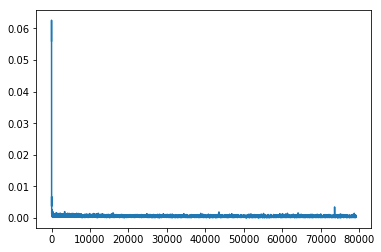

In [11]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [12]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA01_12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'SINKP_NON_UCYZARA01_12_F/model.ckpt-79200'

# Restauramos los modelos

In [14]:
#Ultimo Modelo
path_model = 'SINKP_NON_UCYZARA01_12_F/model.ckpt-79200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  8%|7         | 9/118 [00:00<00:01, 86.56it/s]

Evaluating


100%|##########| 118/118 [00:01<00:00, 89.59it/s]

{'ade': 0.4171511, 'fde': 0.9080485}


In [15]:
#Modelo12
path_model = 'SINKP_NON_UCYZARA01_12/model.ckpt-79200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  4%|4         | 5/118 [00:00<00:02, 48.42it/s]

Evaluating


100%|##########| 118/118 [00:01<00:00, 80.37it/s]


{'ade': 0.41715416, 'fde': 0.90805495}


In [16]:
# Mejor Modelo
path_model = 'SINKP_NON_UCYZARA01-BEST_12/model_best.ckpt-63900'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  5%|5         | 6/118 [00:00<00:01, 56.57it/s]

Evaluating


100%|##########| 118/118 [00:01<00:00, 80.28it/s]

{'ade': 0.41687816, 'fde': 0.9066303}
